# Instalación del paquetes

In [1]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
pip install ucimlrepo pandas numpy seaborn matplotlib scipy scikit-learn imbalanced-learn lightgbm optuna xgboost Jinja2 catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


# Importación de librerías

In [1]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
#from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson, chi2_contingency, spearmanr, kruskal, mannwhitneyu
from sklearn.feature_selection import mutual_info_classif
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
import optuna
from xgboost import XGBClassifier
import math
import time
from catboost import CatBoostClassifier

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
Y = cdc_diabetes_health_indicators.data.targets
data = pd.concat([X, Y], axis=1)

data.head()

ConnectionError: Error connecting to server

In [ ]:
# metadata
#print(cdc_diabetes_health_indicators.metadata)

# informacion de variables
variables_df = pd.DataFrame(cdc_diabetes_health_indicators.variables)
pd.set_option("display.max_colwidth", None)
display(variables_df[['name', 'description']].style.set_properties(**{'text-align': 'left'}))

# variables
numerical_columns = ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns = X.drop(columns=numerical_columns).columns.tolist()
categorical_nonbinary_columns = ['GenHlth','Age', 'Education', 'Income']
categorical_binary_columns = [col for col in categorical_columns if col not in categorical_nonbinary_columns]

print("numerical_columns:", numerical_columns)
print("categorical_columns:", categorical_columns)
print("categorical_nonbinary_columns:", categorical_binary_columns)
print("categorical_binary_columns:", categorical_nonbinary_columns)

,name,description
0,ID,Patient ID
1,Diabetes_binary,0 = no diabetes 1 = prediabetes or diabetes
2,HighBP,0 = no high BP 1 = high BP
3,HighChol,0 = no high cholesterol 1 = high cholesterol
4,CholCheck,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years
5,BMI,Body Mass Index
6,Smoker,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes
7,Stroke,(Ever told) you had a stroke. 0 = no 1 = yes
8,HeartDiseaseorAttack,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes
9,PhysActivity,physical activity in past 30 days - not including job 0 = no 1 = yes


numerical_columns: ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_nonbinary_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_binary_columns: ['GenHlth', 'Age', 'Education', 'Income']


# 1. Exploración de los datos

## 1.1. ProfileReport

In [ ]:
report = ProfileReport(data)
report

NameError: name 'ProfileReport' is not defined

Observaciones:
* ninguna de las variables tienen valores faltantes
* en principio son todo numeros (se comprobará más adelante)
* se comprueba que los valores introducido efectivamente son los que se esperaban (no hay valores incorrectos)
* a simple vista no se observan outlayers muy significativos (se comprobará más adelante)
* existen imbalances en los datos en: CholCheck (77.0%), Stroke (75.5%), HeartDiseaseorAttack (55.0%), HvyAlcoholConsump (68.8%), AnyHealthcare (71.8%) y NoDocbcCost (58.3%).
* el Dataset tiene 11369 (4.5%) filas iguales (duplicadas?) => NO van a eliminarse, ya que Machine Learning Repository afirma lo siguiente: "Each row represents a person participating in this study."

## 1.2. Distribución de las características

### Tipo de distribución
Se analiza si las variables numéricas siguen o no una distribución normal.

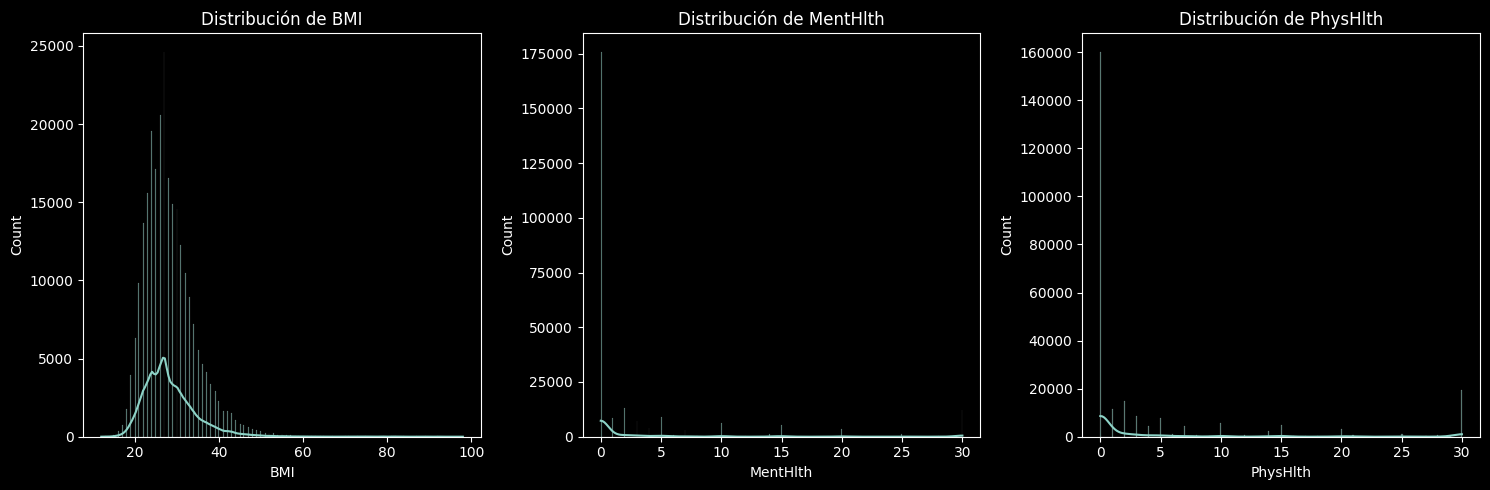


--- Análisis de normalidad para BMI ---
Shapiro-Wilk Test: Estadístico=0.8717, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=126255.7185, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)

--- Análisis de normalidad para MentHlth ---
Shapiro-Wilk Test: Estadístico=0.4869, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=137190.8598, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 253680.
  res = hypotest_fun_out(*samples, **kwds)


D’Agostino’s K^2 Test: Estadístico=104008.5163, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)


In [ ]:
# Graficar histogramas y KDE plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(numerical_columns):
    sns.histplot(X[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

# Pruebas de normalidad
def check_normality(data, var):
    print(f"\n--- Análisis de normalidad para {var} ---")
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    stat, p = normaltest(data)
    print(f"D’Agostino’s K^2 Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    result = anderson(data)
    print("Anderson-Darling Test:")
    for i in range(len(result.critical_values)):
        sig_level = result.significance_level[i]
        crit_val = result.critical_values[i]
        decision = "(Rechaza H0)" if result.statistic > crit_val else "(No se rechaza H0)"
        print(f"  Nivel de significancia {sig_level}% - Valor crítico: {crit_val:.4f} {decision}")

# Aplicar pruebas a cada variable
for var in numerical_columns:
    check_normality(X[var].dropna(), var)

Se concluye que **ninguna de las características numéricas siguen una distribución normal**.

### Desbalanceo de clases

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31452\1777402780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y.Diabetes_binary, palette="Set2")


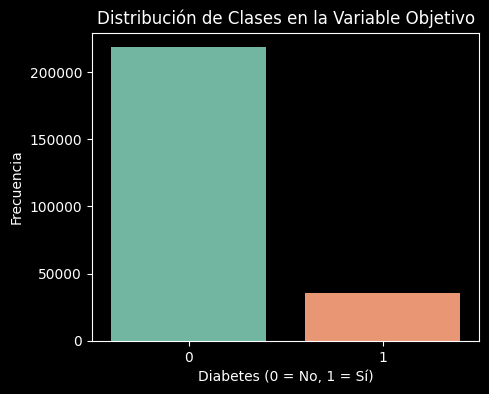

Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64


In [ ]:
# Ver distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(x=Y.Diabetes_binary, palette="Set2")
plt.title("Distribución de Clases en la Variable Objetivo")
plt.xlabel("Diabetes (0 = No, 1 = Sí)")
plt.ylabel("Frecuencia")
plt.show()

# Ver proporción de cada clase
print(Y.Diabetes_binary.value_counts(normalize=True))

### Identificación de outliers

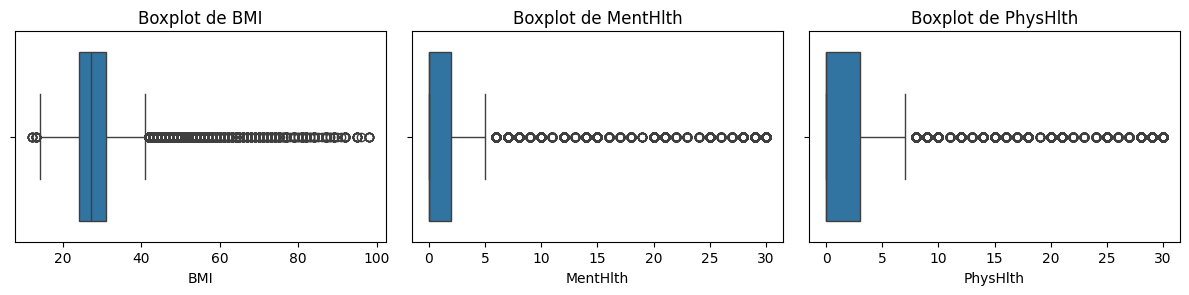

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

## 1.3. Tipo de datos

In [ ]:
data.dtypes

,0
HighBP,int64
HighChol,int64
CholCheck,int64
BMI,int64
Smoker,int64
Stroke,int64
HeartDiseaseorAttack,int64
PhysActivity,int64
Fruits,int64
Veggies,int64


## 1.4. Análisis

### Análisis bivariado
Se realiza un tipo de estudio según el tipo de variable que sean:
* Numérica - numérica: **Spearman**.
* Numérica - categórica binaria: **Mann-Whitney U** (se muestra el p valor).
* Numérica - categórica (+3 categorías): **Kruskal-Wallis**.
* Categórica - categórica: **Cramer's V**.

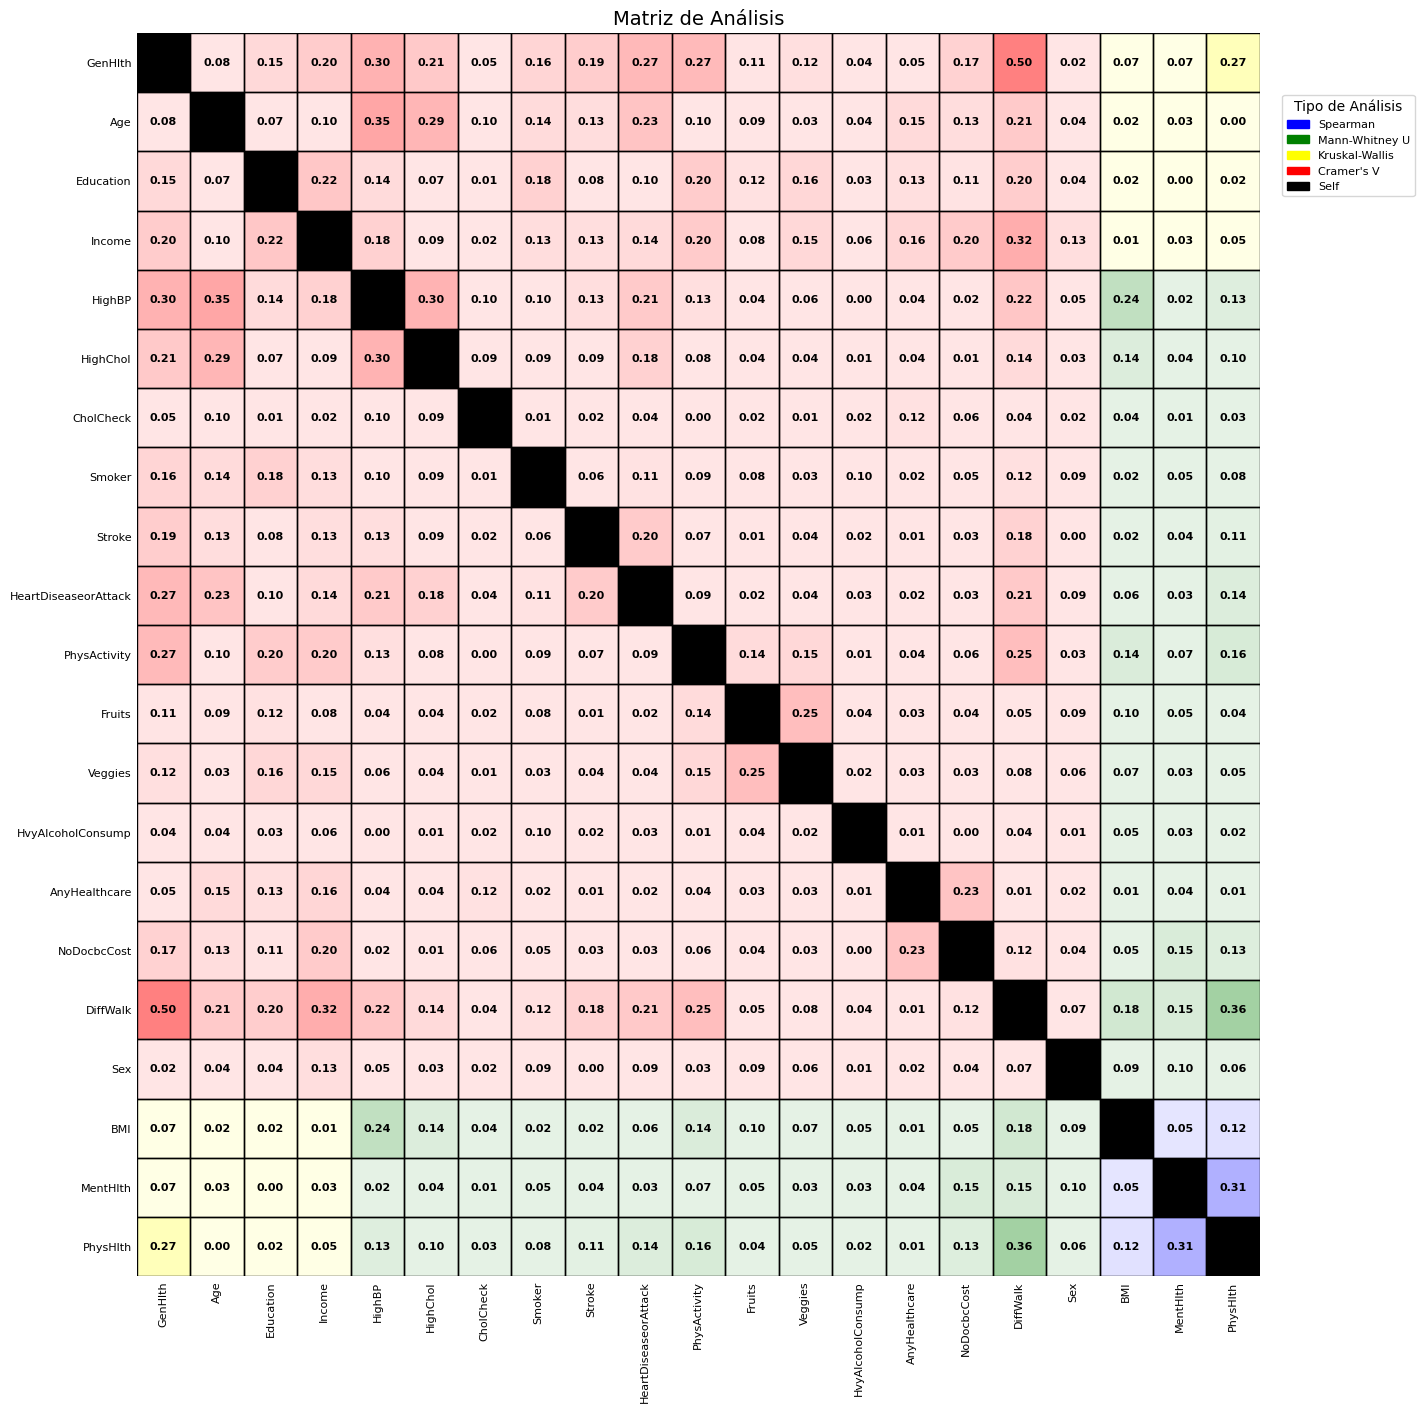

In [ ]:
# Diccionarios para identificación rápida de variables
categorical_vars = set(categorical_nonbinary_columns + categorical_binary_columns)
binary_vars = set(categorical_binary_columns)

def calculate_metric(x, y, x_is_categorical, y_is_categorical, x_is_binary, y_is_binary):
    if not x_is_categorical and not y_is_categorical:
        # Ambas variables son numéricas: uso de correlación de Spearman
        metric, p_value = spearmanr(x, y)
        analysis_type = 'Spearman'
    elif not x_is_categorical and y_is_categorical:
        # x numérica y y categórica
        if y_is_binary:
            # Caso binario: Mann-Whitney U con cálculo del efecto (r = |z|/sqrt(n1+n2))
            group1 = x[y == 0]
            group2 = x[y == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            # y categórica con más de 2 niveles: uso de Kruskal-Wallis y cálculo del efecto (eta²)
            groups = [x[y == cat] for cat in np.unique(y)]
            k = len(groups)
            n = len(x)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                # Efecto estimado: eta² = (H - k + 1) / (n - k)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    elif x_is_categorical and not y_is_categorical:
        # x categórica y y numérica (caso análogo)
        if x_is_binary:
            group1 = y[x == 0]
            group2 = y[x == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            groups = [y[x == cat] for cat in np.unique(x)]
            k = len(groups)
            n = len(y)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    else:
        # Ambas variables categóricas: uso de la prueba chi-cuadrado y cálculo de Cramer's V
        contingency_table = pd.crosstab(x, y)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n_total = contingency_table.values.sum()
        phi2 = chi2 / n_total
        r, k = contingency_table.shape
        try:
            metric = np.sqrt(phi2 / min((k - 1), (r - 1)))
        except ZeroDivisionError:
            metric = 0
        analysis_type = "Cramer's V"
    return metric, p_value, analysis_type

def create_metric_matrix(X, categorical_nonbinary_columns, categorical_binary_columns, numerical_columns):
    all_columns = categorical_nonbinary_columns + categorical_binary_columns + numerical_columns
    n = len(all_columns)
    metric_matrix = np.zeros((n, n))
    analysis_matrix = [[None] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == j:
                metric_matrix[i, j] = 1.0
                analysis_matrix[i][j] = 'Self'
            else:
                x = X[all_columns[i]]
                y = X[all_columns[j]]
                x_is_categorical = all_columns[i] in categorical_vars
                y_is_categorical = all_columns[j] in categorical_vars
                x_is_binary = all_columns[i] in binary_vars
                y_is_binary = all_columns[j] in binary_vars
                metric, p_value, analysis_type = calculate_metric(
                    x, y,
                    x_is_categorical, y_is_categorical,
                    x_is_binary, y_is_binary
                )
                metric_matrix[i, j] = metric
                analysis_matrix[i][j] = analysis_type

    metric_df = pd.DataFrame(metric_matrix, index=all_columns, columns=all_columns)
    analysis_df = pd.DataFrame(analysis_matrix, index=all_columns, columns=all_columns)
    return metric_df, analysis_df

# Generar la matriz de análisis
metric_df, analysis_df = create_metric_matrix(
    X,
    categorical_nonbinary_columns,
    categorical_binary_columns,
    numerical_columns
)

# Definir colores para cada tipo de análisis
analysis_colors = {
    "Spearman": "blue",
    "Mann-Whitney U": "green",
    "Kruskal-Wallis": "yellow",
    "Cramer's V": "red",
    "Self": "black"
}

# Graficar la matriz de análisis
fig, ax = plt.subplots(figsize=(18, 14))
for i in range(metric_df.shape[0]):
    for j in range(metric_df.shape[1]):
        value = metric_df.iloc[i, j]
        analysis_type = analysis_df.iloc[i, j]
        color = analysis_colors.get(analysis_type, "white")
        alpha = max(0.1, min(abs(value), 1))  # transparencia en rango [0.1, 1]
        rgba_color = to_rgba(color, alpha)
        rect = plt.Rectangle((j, i), 1, 1, color=rgba_color, ec='black')
        ax.add_patch(rect)
        ax.text(j + 0.5, i + 0.5, '<0.001' if value < 0.001 else f'{value:.2f}',
                ha='center', va='center', fontsize=8, fontweight='bold')

ax.set_xlim(0, metric_df.shape[1])
ax.set_ylim(0, metric_df.shape[0])
ax.invert_yaxis()
ax.set_xticks(np.arange(metric_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(metric_df.shape[0]) + 0.5)
ax.set_xticklabels(metric_df.columns, rotation=90, fontsize=8)
ax.set_yticklabels(metric_df.index, fontsize=8)
ax.tick_params(axis='both', which='both', length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

# Leyenda
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in analysis_colors.items()]
ax.legend(handles=legend_patches, loc='upper left',
          bbox_to_anchor=(1.02, 0.95), borderaxespad=0.0,
          title="Tipo de Análisis", fontsize=8)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.title("Matriz de Análisis", fontsize=14)
plt.show()

Para Correlación de Spearman 🔵:
* r < 0.10: Correlación despreciable o nula
* 0.10 ≤ r < 0.30: Correlación pequeña o débil
* 0.30 ≤ r < 0.50: Correlación moderada
* 0.50 ≤ r < 0.70: Correlación alta o fuerte
* r ≥ 0.70: Correlación muy fuerte

Para el Tamaño del Efecto derivado de la prueba de Mann-Whitney U 🟢(calculado como * r = |z|/√(n₁+n₂)):
* r ≈ 0.10: Efecto pequeño
* r ≈ 0.30: Efecto moderado
* r ≈ 0.50: Efecto grande

Para la medida de efecto derivada de la prueba de Kruskal-Wallis 🟡(usando eta²):
* 0.01 ≤ η² < 0.06: Efecto pequeño
* 0.06 ≤ η² < 0.14: Efecto moderado
* η² ≥ 0.14: Efecto grande

Para Cramer's V 🔴(utilizado en variables categóricas):
* V < 0.10: Asociación despreciable
* 0.10 ≤ V < 0.30: Asociación débil
* 0.30 ≤ V < 0.50: Asociación moderada
* V ≥ 0.50: Asociación fuerte

Fuente:
Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences (2ª ed.). Lawrence Erlbaum Associates.

### Information Gain
obtenido de: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

Funciona bien con datos categóricos, ordinales y binarios y captura relaciones no lineales.

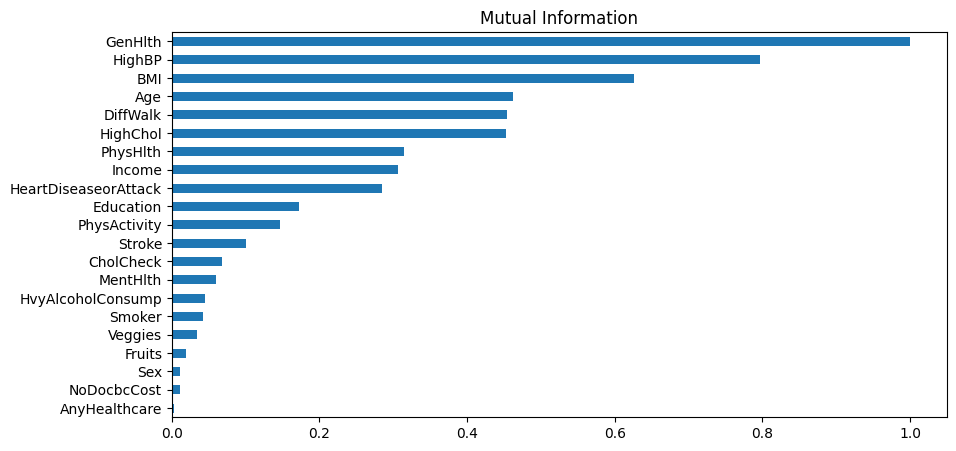

In [ ]:
# Calcular la información mutua
importances = mutual_info_classif(X, Y.Diabetes_binary, discrete_features=True, random_state=42)

# Crear un DataFrame con las importancias de las características
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Normalizar las importancias para comparación
feat_importances /= feat_importances.max()

# Visualizar las importancias de las características
plt.figure(figsize=(10, 5))
feat_importances.sort_values().plot(kind='barh')
plt.title('Mutual Information')
plt.show()

puede ser que el desbalance de las clases afecte a los resultados??

a continuacion:

✅ Se balancea primero el target con SMOTE para evitar que la información mutua esté sesgada hacia la clase mayoritaria.

✅ En lugar de balancear cada característica individualmente, se realiza un submuestreo general para mantener la estructura de correlación entre variables.

✅ Se compara la información mutua antes y después del balanceo para evaluar posibles efectos artificiales introducidos por SMOTE.

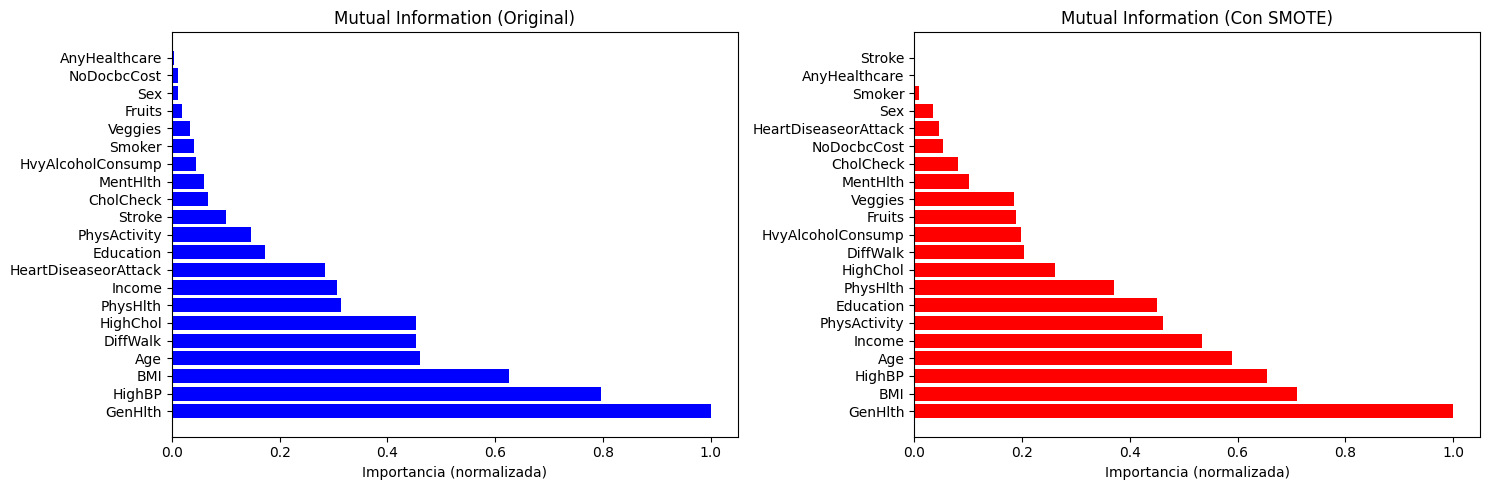

                      Original         SMOTE
Age                   0.461564  5.900373e-01
AnyHealthcare         0.003162  8.047045e-04
BMI                   0.626574  7.093766e-01
CholCheck             0.067869  8.013525e-02
DiffWalk              0.453632  2.035805e-01
Education             0.172791  4.501395e-01
Fruits                0.018651  1.884417e-01
GenHlth               1.000000  1.000000e+00
HeartDiseaseorAttack  0.284593  4.527577e-02
HighBP                0.796362  6.540194e-01
HighChol              0.453215  2.610833e-01
HvyAlcoholConsump     0.045374  1.987966e-01
Income                0.306589  5.338270e-01
MentHlth              0.059504  1.009023e-01
NoDocbcCost           0.010589  5.318546e-02
PhysActivity          0.146907  4.614863e-01
PhysHlth              0.314847  3.710049e-01
Sex                   0.011188  3.471081e-02
Smoker                0.041767  8.438318e-03
Stroke                0.100518  3.771327e-07
Veggies               0.034455  1.848042e-01


In [ ]:
# 1️⃣ Aplicar SMOTE para balancear el target antes del cálculo de MI
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, Y.Diabetes_binary)

# 2️⃣ Definir función para calcular información mutua sin modificar cada variable individualmente
def calculate_mutual_info(X, y, random_state=42):
    """
    Calcula la información mutua entre cada variable en X y el target y sin modificar las variables individualmente.
    """
    return mutual_info_classif(X, y, discrete_features=True, random_state=random_state)

# 3️⃣ Calcular información mutua en el dataset original (sin balancear)
mi_original = calculate_mutual_info(X, Y.Diabetes_binary)

# 4️⃣ Calcular información mutua en el dataset balanceado con SMOTE
mi_smote = calculate_mutual_info(X_smote, y_smote)

# 5️⃣ Crear DataFrames con los resultados
mi_series_original = pd.Series(mi_original, index=X.columns).sort_values(ascending=False)
mi_series_smote = pd.Series(mi_smote, index=X_smote.columns).sort_values(ascending=False)

# Normalizar ambas series para comparación
mi_series_original /= mi_series_original.max()
mi_series_smote /= mi_series_smote.max()

# 6️⃣ Visualización comparativa de Mutual Information antes y después de SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Mutual Information en el dataset original
axes[0].barh(mi_series_original.index, mi_series_original, color="blue")
axes[0].set_title("Mutual Information (Original)")
axes[0].set_xlabel("Importancia (normalizada)")

# Gráfico de Mutual Information en el dataset balanceado con SMOTE
axes[1].barh(mi_series_smote.index, mi_series_smote, color="red")
axes[1].set_title("Mutual Information (Con SMOTE)")
axes[1].set_xlabel("Importancia (normalizada)")

plt.tight_layout()
plt.show()

# Comparar valores numéricamente
mi_comparison = pd.DataFrame({"Original": mi_series_original, "SMOTE": mi_series_smote})
print(mi_comparison)

habría que comentar la capacidad predictiva del modelo con variables que representan objetividad como GenHealth....

### Correlación de pearson
No es la mejor opción dado que la mayoría de variables son categóricas.

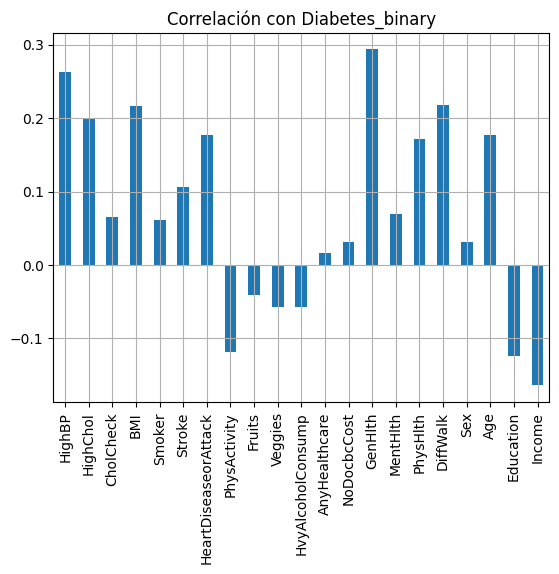

In [ ]:
X.corrwith(Y.Diabetes_binary).plot(kind='bar', grid=True, title="Correlación con Diabetes_binary");

# 2. Preprocesamiento


## Eliminación de variables

* Estas variables tienen información mutua extremadamente baja en ambos escenarios, lo que indica que no aportan valor predictivo al modelo.
 * **AnyHealthcare**
 * **Sex**
 * **Smoker**
 * **Stroke**
 * **NoDocbcCost**
* Estas variables están correlacionadas con otras.
 * **DiffWalk** (fuertemente correlacionado con GenHlth)
 * **PhysHlth** (fuertemente correlacionado con GenHlth)


// COMENTARIO DE CHATGPT //
📌 Análisis de Variables
1️⃣ Variables con MI baja en ambos casos (Candidatas a eliminación)

Variable	MI Original	MI SMOTE
AnyHealthcare	0.003162	0.000804

Sex	0.011188	0.034711

Smoker	0.041767	0.008438

Stroke	0.100518	0.0000003

NoDocbcCost	0.010589	0.053185


Estas variables tienen información mutua extremadamente baja en ambos escenarios, lo que indica que no aportan valor predictivo al modelo.
Se recomienda eliminarlas.

2️⃣ Variables con un aumento drástico tras SMOTE (Posibles Sesgos)

Variable	MI Original	MI SMOTE	Aumento (%)

Fruits	0.018651	0.188442	🔺 +909%

Veggies	0.034455	0.184804	🔺 +436%

HvyAlcoholConsump	0.045374	0.198796	🔺 +338%

Si el modelo final va a ser entrenado con datos desbalanceados (sin SMOTE en el entrenamiento), estas variables deben eliminarse porque su alta MI después de SMOTE no refleja una verdadera relación con la variable objetivo.

Si SMOTE se aplicará en el entrenamiento del modelo, podríamos dejarlas y validar su impacto en el rendimiento final.

⚠ Recomendación:

🔸 Si queremos evitar cualquier sesgo, eliminarlas.

🔸 Si queremos probar su efecto, hacer dos versiones del modelo (con y sin ellas) y comparar.


3️⃣ Variables con reducción drástica tras SMOTE (Candidatas a eliminación)

Variable	MI Original	MI SMOTE	Reducción (%)

DiffWalk	0.453632	0.203580	🔻 -55%

HeartDiseaseorAttack	0.284593	0.045276	🔻 -84%

HighChol	0.453215	0.261083	🔻 -42%

HeartDiseaseorAttack pierde casi toda su relación con la variable objetivo tras SMOTE, por lo que su influencia inicial era probablemente un efecto del desbalanceo.

Recomendamos eliminarla.

DiffWalk y HighChol aún mantienen cierta relevancia tras SMOTE, por lo que podríamos conservarlas.

In [ ]:
# variables definitivas
# Definir las variables a eliminar
deleted_vars = [
    "AnyHealthcare",
    "Sex",
    "NoDocbcCost",
    "Smoker",
    "Stroke",
    "PhysHlth",
    "DiffWalk",
]

# Crear las nuevas X e Y
X_filtered = X.drop(columns=deleted_vars)
Y_filtered = Y.copy()  # No modificamos la variable objetivo

# Actualizar las listas de variables después de la eliminación
numerical_columns_filtered = [col for col in numerical_columns if col not in deleted_vars]
categorical_columns_filtered = [col for col in categorical_columns if col not in deleted_vars]
categorical_nonbinary_columns_filtered = [col for col in categorical_nonbinary_columns if col not in deleted_vars]
categorical_binary_columns_filtered = [col for col in categorical_binary_columns if col not in deleted_vars]

# Imprimir las nuevas listas de variables
print("Variables numéricas:", numerical_columns_filtered)
print("Variables categóricas:", categorical_columns_filtered)
print("Variables categóricas no binarias:", categorical_nonbinary_columns_filtered)
print("Variables categóricas binarias:", categorical_binary_columns_filtered)


NameError: name 'X' is not defined

## Tratamiento de Outliers y categorización (BMI)
Segun ([fuente](https://www.nhs.uk/conditions/obesity/)):
* Underweight: Below 18.5
* Normal weight: 18.5–24.9
* Pre-obesity: 25.0–29.9
* Obesity class I: 30.0–34.9
* Obesity class II: 35.0–39.9
* Obesity class III: Above 40


Como físicamente creemos que es posible tener un BMI mucho mayor que 40 (p.ej. teniendo una baja estatura y un peso muy elevado), concluimos que vamos a categorizar la variable y no eliminar ninguna fila del dataset.

In [ ]:
# Definir los intervalos y etiquetas de clasificación de BMI
bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]  # np.inf representa valores mayores a 40
bmi_labels = ["Underweight", "Normal weight", "Pre-obesity", "Obesity class I", "Obesity class II", "Obesity class III"]

# Crear una nueva columna categórica para BMI
X_filtered["BMI"] = pd.cut(X_filtered["BMI"], bins=bmi_bins, labels=bmi_labels, right=True).cat.codes.astype("int64")

# Actualizar las listas de variables categóricas y numéricas
categorical_columns_filtered.append("BMI")
categorical_nonbinary_columns_filtered.append("BMI")  # Ahora es categórica con más de 2 niveles

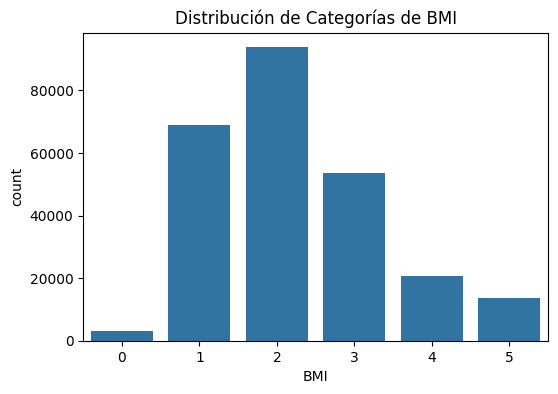

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=X_filtered['BMI'])
plt.title("Distribución de Categorías de BMI")
plt.show()

## Train-test split

In [ ]:
# División en 80% train - 20% test con estratificación del target
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, Y_filtered, test_size=0.2, random_state=42, stratify=Y_filtered
)

# Verificar tamaños de los conjuntos
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Distribución del target en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución del target en prueba:\n", y_test.value_counts(normalize=True))


Tamaño de X_train: (202944, 14)
Tamaño de X_test: (50736, 14)
Distribución del target en entrenamiento:
 Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Distribución del target en prueba:
 Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64


# 3. Implementación de modelo trivial

In [ ]:
# Definir el DummyClassifier que siempre predice la clase mayoritaria
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
dummy_clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_dummy = dummy_clf.predict(X_test)

# Calcular AUC como métrica principal
auc_dummy = roc_auc_score(y_test, y_pred_dummy)

# Validación cruzada (10-Fold CV) para ver estabilidad
cv_scores = cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring="roc_auc")

# Mostrar resultados
print(f"AUC DummyClassifier (Test Set): {auc_dummy:.4f}")
print(f"AUC DummyClassifier (Cross-Validation Mean): {cv_scores.mean():.4f}")
print(f"AUC DummyClassifier (Cross-Validation Std Dev): {cv_scores.std():.4f}")


AUC DummyClassifier (Test Set): 0.5000
AUC DummyClassifier (Cross-Validation Mean): 0.5000
AUC DummyClassifier (Cross-Validation Std Dev): 0.0000


# 4. Implementación de modelos predictivos
* para encontrar los mejores parametros: RandomizedSearchCV o Bayesian Optimization
* para balancear las características y el target: balanced_weight (en modelos que lo permitan), SMOTE o undersampling
* posteriormente se puede utilizar SHAP para que seleccione automaticamente las variables y comprobar la seleccion que hicimos.

In [ ]:
import multiprocessing
print("Núcleos disponibles:", multiprocessing.cpu_count())

Núcleos disponibles: 16


In [ ]:
n_jobs = 6  # Número de núcleos a utilizar

## RandomForestClassifier
Modelo base fuerte, maneja datos categóricos sin problemas y es robusto.

PARAMETROS  EVALUADOS en RandomForestClassifier:
* **n_estimators** (cantidad de árboles): 100 es un buen punto de partida, pero Random Forest suele mejorar hasta ~300-500 árboles antes de volverse ineficiente.
Valores mayores a 500 no suelen mejorar el rendimiento significativamente en datasets medianos/grandes. (Breiman, L. (2001). Random Forests en Machine Learning Journal.)
* **max_depth** (profundidad máxima del árbol): None permite que el árbol crezca completamente (puede sobreajustar).
Valores pequeños (10-20) controlan el overfitting y mejoran la capacidad de generalización.
Más de 30 generalmente es innecesario, ya que la mayoría de los datasets no requieren árboles tan profundos. (Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning.)
* **min_samples_split** (Mínimo de muestras para dividir un nodo): Valores bajos (2-5) permiten que el árbol crezca más profundo y capture más patrones.
Valores más altos (10+) reducen la profundidad del árbol y evitan el sobreajuste. (Scikit-learn documentation: Empirical Studies on Decision Trees.)
* **min_samples_leaf** (Mínimo de muestras en las hojas finales): 1 es el valor predeterminado y permite capturar patrones raros.
2 o 4 evitan ramas muy específicas y reducen el sobreajuste. (Breiman, L. (2001). Random Forests.)
* **max_features** (Número de características consideradas en cada split): sqrt (raíz cuadrada del número total de features) es la configuración estándar en Random Forest.
log2 (logaritmo en base 2 del número total de features) reduce aún más la correlación entre árboles, lo cual puede mejorar estabilidad. (Ho, Tin Kam (1998). Random Decision Forests.)
* **bootstrap** (Uso de muestreo con reemplazo). True (predeterminado) → Cada árbol se entrena con un subconjunto aleatorio del dataset.
False (Sin reemplazo) → Cada árbol usa TODO el dataset. (Breiman, L. (2001). Bagging Predictors.)

Nota de RandomizedSearchCV:

RandomizedSearchCV ya incorpora la validación cruzada internamente mediante el parámetro cv (que se define como un StratifiedKFold con 10 folds). Esto significa que, durante la búsqueda de hiperparámetros, el proceso de validación cruzada se ejecuta en cada combinación evaluada, por lo que no se ha utilizado cross_val_score. Por otro lado, Optuna no incorpora de forma interna una estrategia de validación cruzada, por lo que hemos definido la función cross_val_score para evaluar cada conjunto de hiperparámetros.

Se calcula el tiempo de ejecución de 1 iteración del modelo

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier

# Toma una pequeña muestra del conjunto de entrenamiento, o ejecuta un solo fold
temp_model = RandomForestClassifier(random_state=42, n_jobs=6)
start = time.time()
temp_model.fit(X_train, y_train)  # O usa un split representativo
end = time.time()
print("Tiempo de entrenamiento para este ajuste (VS CODE): {:.2f} segundos".format(end - start))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Tiempo de entrenamiento para este ajuste (VS CODE): 5.44 segundos


### Modelo 1: RandomizedSearchCV + balanced_weight

In [ ]:
# Hiperparámetros enfocados en balanced_weight
param_distributions_rfc_1 = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Instanciar el RandomForestClassifier
model_rfc_1 = RandomForestClassifier(random_state=42, n_jobs=n_jobs)

# Estrategia de validación cruzada estratificada (10 folds)
cv_strategy_rfc_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV optimizando únicamente AUC
random_search_rfc_1 = RandomizedSearchCV(
    estimator=model_rfc_1,
    param_distributions=param_distributions_rfc_1,
    n_iter=25,  # Reducir para limitar el tiempo
    cv=cv_strategy_rfc_1,
    scoring='roc_auc',
    refit=True,
    verbose=2,
    random_state=42,
    n_jobs=n_jobs
)

start_time_rfc_1 = time.time()
random_search_rfc_1.fit(X_train, y_train)
end_time_rfc_1 = time.time()
execution_time_rfc_1 = (end_time_rfc_1 - start_time_rfc_1) / 60

print("Combination 1: RandomizedSearchCV + Balanced Weight")
print("Best hyperparameters found:")
print(random_search_rfc_1.best_params_)
print("Best CV AUC: {:.4f}".format(random_search_rfc_1.best_score_))
print("Total search time: {:.2f} minutes".format(execution_time_rfc_1))

# Evaluación final en el conjunto de prueba
best_model_rfc_1 = random_search_rfc_1.best_estimator_
y_pred_proba_rfc_1 = best_model_rfc_1.predict_proba(X_test)[:, 1]
y_pred_rfc_1 = best_model_rfc_1.predict(X_test)

auc_rfc_1 = roc_auc_score(y_test, y_pred_proba_rfc_1)
accuracy_rfc_1 = accuracy_score(y_test, y_pred_rfc_1)
f1_rfc_1 = f1_score(y_test, y_pred_rfc_1)
recall_rfc_1 = recall_score(y_test, y_pred_rfc_1)
precision_rfc_1 = precision_score(y_test, y_pred_rfc_1)
conf_matrix_rfc_1 = confusion_matrix(y_test, y_pred_rfc_1)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_1))
print("Accuracy: {:.4f}".format(accuracy_rfc_1))
print("F1 Score: {:.4f}".format(f1_rfc_1))
print("Recall: {:.4f}".format(recall_rfc_1))
print("Precision: {:.4f}".format(precision_rfc_1))
print("Confusion Matrix:")
print(conf_matrix_rfc_1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Combination 1: RandomizedSearchCV + Balanced Weight
Best hyperparameters found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
Best CV AUC: 0.8250
Total search time: 65.16 minutes

Test set results:
AUC: 0.8205
Accuracy: 0.7252
F1 Score: 0.4387
Recall: 0.7705
Precision: 0.3066
Confusion Matrix:
[[31348 12319]
 [ 1622  5447]]


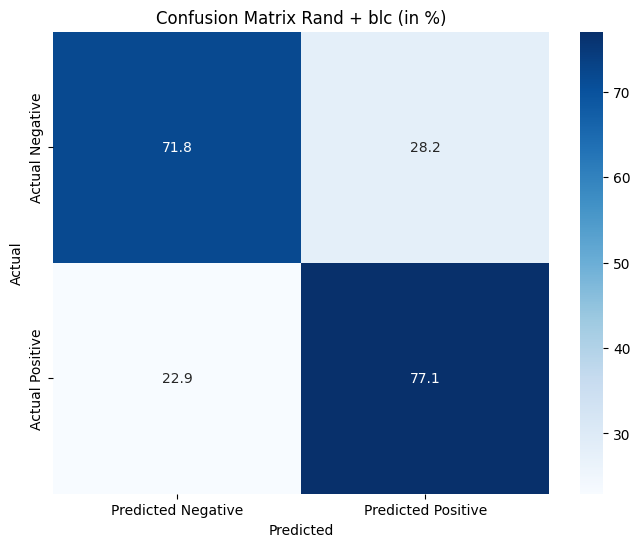

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_1.astype('float') / conf_matrix_rfc_1.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Rand + blc (in %)')
plt.show()

### Modelo 2: RandomizedSearchCV + Oversampling

In [ ]:
# Pipeline con SMOTE seguido de RandomForestClassifier
pipeline_rfc_2 = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=n_jobs))
])

# Hiperparámetros para el clasificador (prefijados con "classifier__")
param_distributions_rfc_2 = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

cv_strategy_rfc_2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search_rfc_2 = RandomizedSearchCV(
    estimator=pipeline_rfc_2,
    param_distributions=param_distributions_rfc_2,
    n_iter=25,
    cv=cv_strategy_rfc_2,
    scoring='roc_auc',
    refit=True,
    verbose=2,
    random_state=42,
    n_jobs=n_jobs
)

start_time_rfc_2 = time.time()
random_search_rfc_2.fit(X_train, y_train)
end_time_rfc_2 = time.time()
execution_time_rfc_2 = (end_time_rfc_2 - start_time_rfc_2) / 60

print("Combination 2: RandomizedSearchCV + Oversampling (SMOTE)")
print("Best hyperparameters found:")
print(random_search_rfc_2.best_params_)
print("Best CV AUC: {:.4f}".format(random_search_rfc_2.best_score_))
print("Total search time: {:.2f} minutes".format(execution_time_rfc_2))

# Evaluación final en el conjunto de prueba
best_model_rfc_2 = random_search_rfc_2.best_estimator_
y_pred_proba_rfc_2 = best_model_rfc_2.predict_proba(X_test)[:, 1]
y_pred_rfc_2 = best_model_rfc_2.predict(X_test)

auc_rfc_2 = roc_auc_score(y_test, y_pred_proba_rfc_2)
accuracy_rfc_2 = accuracy_score(y_test, y_pred_rfc_2)
f1_rfc_2 = f1_score(y_test, y_pred_rfc_2)
recall_rfc_2 = recall_score(y_test, y_pred_rfc_2)
precision_rfc_2 = precision_score(y_test, y_pred_rfc_2)
conf_matrix_rfc_2 = confusion_matrix(y_test, y_pred_rfc_2)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_2))
print("Accuracy: {:.4f}".format(accuracy_rfc_2))
print("F1 Score: {:.4f}".format(f1_rfc_2))
print("Recall: {:.4f}".format(recall_rfc_2))
print("Precision: {:.4f}".format(precision_rfc_2))
print("Confusion Matrix:")
print(conf_matrix_rfc_2)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Combination 2: RandomizedSearchCV + Oversampling (SMOTE)
Best hyperparameters found:
{'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__bootstrap': False}
Best CV AUC: 0.8176
Total search time: 118.33 minutes

Test set results:
AUC: 0.8134
Accuracy: 0.7052
F1 Score: 0.4260
Recall: 0.7851
Precision: 0.2923
Confusion Matrix:
[[30227 13440]
 [ 1519  5550]]


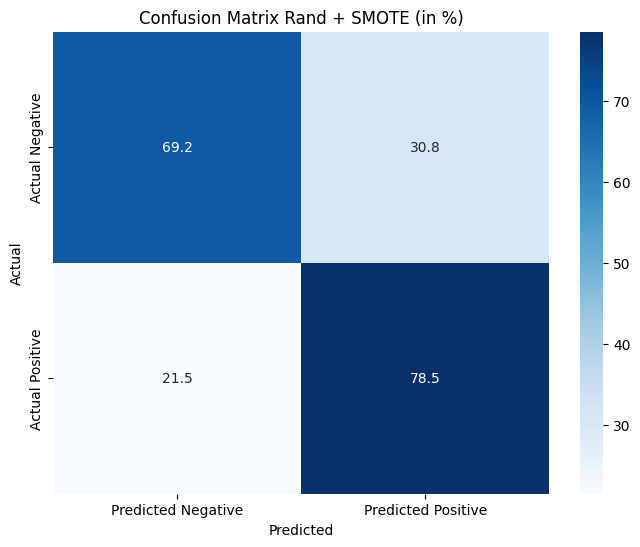

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_2.astype('float') / conf_matrix_rfc_2.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Rand + SMOTE (in %)')
plt.show()

### Modelo 3: RandomizedSearchCV + Undersampling

In [ ]:
# Pipeline con RandomUnderSampler seguido de RandomForestClassifier
pipeline_rfc_3 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=n_jobs))
])

param_distributions_rfc_3 = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

cv_strategy_rfc_3 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search_rfc_3 = RandomizedSearchCV(
    estimator=pipeline_rfc_3,
    param_distributions=param_distributions_rfc_3,
    n_iter=25,
    cv=cv_strategy_rfc_3,
    scoring='roc_auc',
    refit=True,
    verbose=2,
    random_state=42,
    n_jobs=n_jobs
)

start_time_rfc_3 = time.time()
random_search_rfc_3.fit(X_train, y_train)
end_time_rfc_3 = time.time()
execution_time_rfc_3 = (end_time_rfc_3 - start_time_rfc_3) / 60

print("Combination 3: RandomizedSearchCV + Undersampling")
print("Best hyperparameters found:")
print(random_search_rfc_3.best_params_)
print("Best CV AUC: {:.4f}".format(random_search_rfc_3.best_score_))
print("Total search time: {:.2f} minutes".format(execution_time_rfc_3))

# Evaluación final en el conjunto de prueba
best_model_rfc_3 = random_search_rfc_3.best_estimator_
y_pred_proba_rfc_3 = best_model_rfc_3.predict_proba(X_test)[:, 1]
y_pred_rfc_3 = best_model_rfc_3.predict(X_test)

auc_rfc_3 = roc_auc_score(y_test, y_pred_proba_rfc_3)
accuracy_rfc_3 = accuracy_score(y_test, y_pred_rfc_3)
f1_rfc_3 = f1_score(y_test, y_pred_rfc_3)
recall_rfc_3 = recall_score(y_test, y_pred_rfc_3)
precision_rfc_3 = precision_score(y_test, y_pred_rfc_3)
conf_matrix_rfc_3 = confusion_matrix(y_test, y_pred_rfc_3)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_3))
print("Accuracy: {:.4f}".format(accuracy_rfc_3))
print("F1 Score: {:.4f}".format(f1_rfc_3))
print("Recall: {:.4f}".format(recall_rfc_3))
print("Precision: {:.4f}".format(precision_rfc_3))
print("Confusion Matrix:")
print(conf_matrix_rfc_3)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Combination 3: RandomizedSearchCV + Undersampling
Best hyperparameters found:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__bootstrap': True}
Best CV AUC: 0.8244
Total search time: 8.66 minutes

Test set results:
AUC: 0.8198
Accuracy: 0.7131
F1 Score: 0.4341
Recall: 0.7898
Precision: 0.2993
Confusion Matrix:
[[30596 13071]
 [ 1486  5583]]


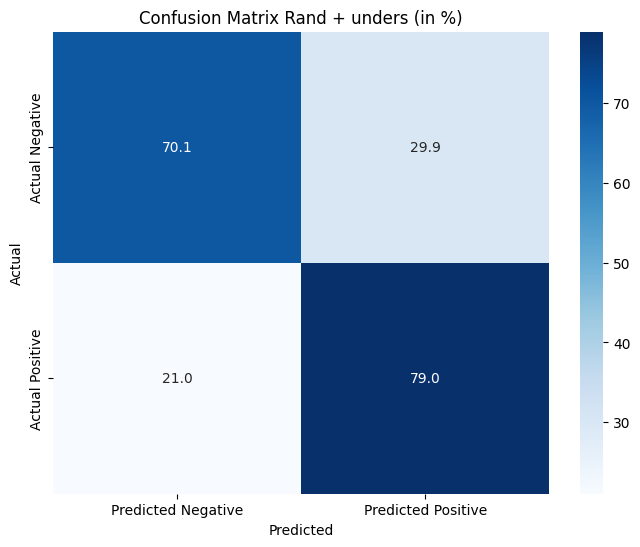

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_3.astype('float') / conf_matrix_rfc_3.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Rand + unders (in %)')
plt.show()

### Modelo 4: Optuna + balanced_weight

In [ ]:
def objective_bw_rfc_4(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])

    model_rfc_4 = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=42,
        n_jobs=n_jobs
    )

    cv_strategy_rfc_4 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model_rfc_4, X_train, y_train, cv=cv_strategy_rfc_4, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_bw_rfc_4 = time.time()
study_bw_rfc_4 = optuna.create_study(direction='maximize')
study_bw_rfc_4.optimize(objective_bw_rfc_4, n_trials=25)
end_time_optuna_bw_rfc_4 = time.time()
execution_time_optuna_bw_rfc_4 = (end_time_optuna_bw_rfc_4 - start_time_optuna_bw_rfc_4) / 60

print("Combination 4: Optuna + Balanced Weight")
print("Best trial:")
print(study_bw_rfc_4.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_bw_rfc_4))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_rfc_4 = study_bw_rfc_4.best_trial.params

best_model_rfc_4 = RandomForestClassifier(
    n_estimators=best_params_rfc_4['n_estimators'],
    max_depth=best_params_rfc_4['max_depth'],
    min_samples_split=best_params_rfc_4['min_samples_split'],
    min_samples_leaf=best_params_rfc_4['min_samples_leaf'],
    bootstrap=best_params_rfc_4['bootstrap'],
    class_weight=best_params_rfc_4['class_weight'],
    random_state=42,
    n_jobs=n_jobs
)

best_model_rfc_4.fit(X_train, y_train)

y_pred_proba_rfc_4 = best_model_rfc_4.predict_proba(X_test)[:, 1]
y_pred_rfc_4 = best_model_rfc_4.predict(X_test)

auc_rfc_4 = roc_auc_score(y_test, y_pred_proba_rfc_4)
accuracy_rfc_4 = accuracy_score(y_test, y_pred_rfc_4)
f1_rfc_4 = f1_score(y_test, y_pred_rfc_4)
recall_rfc_4 = recall_score(y_test, y_pred_rfc_4)
precision_rfc_4 = precision_score(y_test, y_pred_rfc_4)
conf_matrix_rfc_4 = confusion_matrix(y_test, y_pred_rfc_4)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_4))
print("Accuracy: {:.4f}".format(accuracy_rfc_4))
print("F1 Score: {:.4f}".format(f1_rfc_4))
print("Recall: {:.4f}".format(recall_rfc_4))
print("Precision: {:.4f}".format(precision_rfc_4))
print("Confusion Matrix:")
print(conf_matrix_rfc_4)

[I 2025-03-29 09:44:09,411] A new study created in memory with name: no-name-9bc71e83-a73a-4dac-85b5-f3e70fcd2ddb
[I 2025-03-29 09:48:40,841] Trial 0 finished with value: 0.7771372843399619 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7771372843399619.
[I 2025-03-29 09:49:18,591] Trial 1 finished with value: 0.7435190158811718 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7771372843399619.
[I 2025-03-29 09:52:20,676] Trial 2 finished with value: 0.7937904766137983 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7937904766137983.
[I 2025-03-29 09:54:29,792] Trial 3 finished with value: 0.7952

Combination 4: Optuna + Balanced Weight
Best trial:
FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.825058922513335], datetime_start=datetime.datetime(2025, 3, 29, 9, 57, 58, 592733), datetime_complete=datetime.datetime(2025, 3, 29, 10, 0, 28, 371984), params={'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False)), 'class_weight': CategoricalDistribution(choices=('balanced', 'balanced_subsample'))}, trial_id=7, value=None)
Total optimization time: 57.74 minutes

Test set results:
AUC: 0.8205
Accuracy: 0.7251
F1 Scor

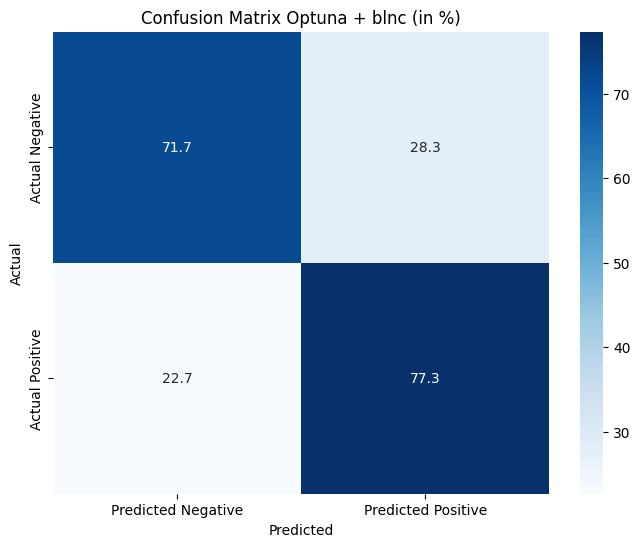

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_4.astype('float') / conf_matrix_rfc_4.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Optuna + blnc (in %)')
plt.show()

### Modelo 5: Optuna + Oversampling

In [ ]:
def objective_os_rfc_5(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    pipeline_rfc_5 = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    cv_strategy_rfc_5 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline_rfc_5, X_train, y_train, cv=cv_strategy_rfc_5, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_os_rfc_5 = time.time()
study_os_rfc_5 = optuna.create_study(direction='maximize')
study_os_rfc_5.optimize(objective_os_rfc_5, n_trials=25)
end_time_optuna_os_rfc_5 = time.time()
execution_time_optuna_os_rfc_5 = (end_time_optuna_os_rfc_5 - start_time_optuna_os_rfc_5) / 60

print("Combination 5: Optuna + Oversampling (SMOTE)")
print("Best trial:")
print(study_os_rfc_5.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_os_rfc_5))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_rfc_5 = study_os_rfc_5.best_trial.params

pipeline_rfc_5 = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params_rfc_5['n_estimators'],
        max_depth=best_params_rfc_5['max_depth'],
        min_samples_split=best_params_rfc_5['min_samples_split'],
        min_samples_leaf=best_params_rfc_5['min_samples_leaf'],
        bootstrap=best_params_rfc_5['bootstrap'],
        random_state=42,
        n_jobs=n_jobs
    ))
])

pipeline_rfc_5.fit(X_train, y_train)

y_pred_proba_rfc_5 = pipeline_rfc_5.predict_proba(X_test)[:, 1]
y_pred_rfc_5 = pipeline_rfc_5.predict(X_test)

auc_rfc_5 = roc_auc_score(y_test, y_pred_proba_rfc_5)
accuracy_rfc_5 = accuracy_score(y_test, y_pred_rfc_5)
f1_rfc_5 = f1_score(y_test, y_pred_rfc_5)
recall_rfc_5 = recall_score(y_test, y_pred_rfc_5)
precision_rfc_5 = precision_score(y_test, y_pred_rfc_5)
conf_matrix_rfc_5 = confusion_matrix(y_test, y_pred_rfc_5)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_5))
print("Accuracy: {:.4f}".format(accuracy_rfc_5))
print("F1 Score: {:.4f}".format(f1_rfc_5))
print("Recall: {:.4f}".format(recall_rfc_5))
print("Precision: {:.4f}".format(precision_rfc_5))
print("Confusion Matrix:")
print(conf_matrix_rfc_5)

[I 2025-03-29 13:01:18,381] A new study created in memory with name: no-name-393b8e4e-9220-4981-81ae-8985e5b8b53e
[I 2025-03-29 13:11:56,778] Trial 0 finished with value: 0.7395980947711214 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.7395980947711214.
[I 2025-03-29 13:18:48,808] Trial 1 finished with value: 0.7859497509822078 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7859497509822078.
[I 2025-03-29 13:23:27,750] Trial 2 finished with value: 0.7393282692817182 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.7859497509822078.
[I 2025-03-29 13:24:37,563] Trial 3 finished with value: 0.8173773054407579 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_spl

Combination 5: Optuna + Oversampling (SMOTE)
Best trial:
FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.8175932399846658], datetime_start=datetime.datetime(2025, 3, 29, 13, 56, 5, 967635), datetime_complete=datetime.datetime(2025, 3, 29, 13, 59, 20, 682684), params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=16, value=None)
Total optimization time: 86.40 minutes


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Test set results:
AUC: 0.8134
Accuracy: 0.7059
F1 Score: 0.4262
Recall: 0.7840
Precision: 0.2926
Confusion Matrix:
[[30271 13396]
 [ 1527  5542]]


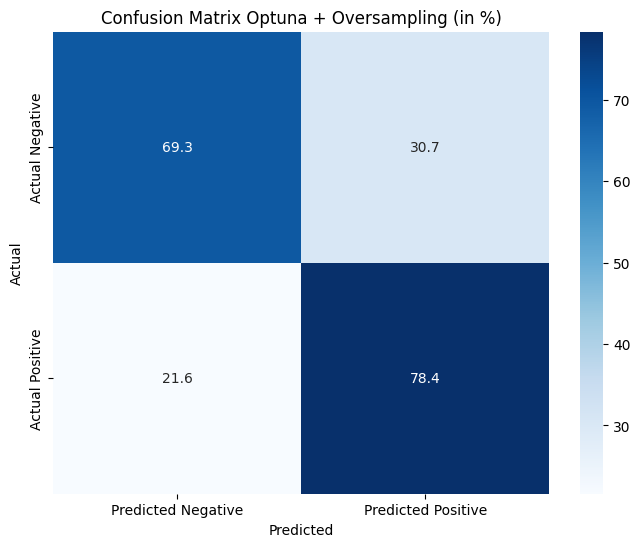

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_5.astype('float') / conf_matrix_rfc_5.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Optuna + Oversampling (in %)')
plt.show()

### Modelo 6: Optuna + Undersampling

In [ ]:
def objective_us_rfc_6(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    pipeline_rfc_6 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    cv_strategy_rfc_6 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline_rfc_6, X_train, y_train, cv=cv_strategy_rfc_6, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_us_rfc_6 = time.time()
study_us_rfc_6 = optuna.create_study(direction='maximize')
study_us_rfc_6.optimize(objective_us_rfc_6, n_trials=25)
end_time_optuna_us_rfc_6 = time.time()
execution_time_optuna_us_rfc_6 = (end_time_optuna_us_rfc_6 - start_time_optuna_us_rfc_6) / 60

print("Combination 6: Optuna + Undersampling")
print("Best trial:")
print(study_us_rfc_6.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_us_rfc_6))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_rfc_6 = study_us_rfc_6.best_trial.params

pipeline_rfc_6 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params_rfc_6['n_estimators'],
        max_depth=best_params_rfc_6['max_depth'],
        min_samples_split=best_params_rfc_6['min_samples_split'],
        min_samples_leaf=best_params_rfc_6['min_samples_leaf'],
        bootstrap=best_params_rfc_6['bootstrap'],
        random_state=42,
        n_jobs=n_jobs
    ))
])

pipeline_rfc_6.fit(X_train, y_train)

y_pred_proba_rfc_6 = pipeline_rfc_6.predict_proba(X_test)[:, 1]
y_pred_rfc_6 = pipeline_rfc_6.predict(X_test)

auc_rfc_6 = roc_auc_score(y_test, y_pred_proba_rfc_6)
accuracy_rfc_6 = accuracy_score(y_test, y_pred_rfc_6)
f1_rfc_6 = f1_score(y_test, y_pred_rfc_6)
recall_rfc_6 = recall_score(y_test, y_pred_rfc_6)
precision_rfc_6 = precision_score(y_test, y_pred_rfc_6)
conf_matrix_rfc_6 = confusion_matrix(y_test, y_pred_rfc_6)

print("\nTest set results:")
print("AUC: {:.4f}".format(auc_rfc_6))
print("Accuracy: {:.4f}".format(accuracy_rfc_6))
print("F1 Score: {:.4f}".format(f1_rfc_6))
print("Recall: {:.4f}".format(recall_rfc_6))
print("Precision: {:.4f}".format(precision_rfc_6))
print("Confusion Matrix:")
print(conf_matrix_rfc_6)

[I 2025-03-29 14:47:05,072] A new study created in memory with name: no-name-e21f7a9b-6037-453f-8507-c0dbc606284d
[I 2025-03-29 14:47:34,352] Trial 0 finished with value: 0.8124142270854623 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8124142270854623.
[I 2025-03-29 14:47:59,255] Trial 1 finished with value: 0.8124142270854623 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8124142270854623.
[I 2025-03-29 14:48:17,186] Trial 2 finished with value: 0.8246855528281933 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.8246855528281933.
[I 2025-03-29 14:48:36,003] Trial 3 finished with value: 0.8011944265045463 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_spli

Combination 6: Optuna + Undersampling
Best trial:
FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.8246855528281933], datetime_start=datetime.datetime(2025, 3, 29, 14, 47, 59, 256978), datetime_complete=datetime.datetime(2025, 3, 29, 14, 48, 17, 186922), params={'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=2, value=None)
Total optimization time: 6.62 minutes

Test set results:
AUC: 0.8202
Accuracy: 0.7148
F1 Score: 0.4350
Recall: 0.7882
Precision: 0.3004
Confusion Matrix:
[[30692 12975]
 [ 1497  5572]]


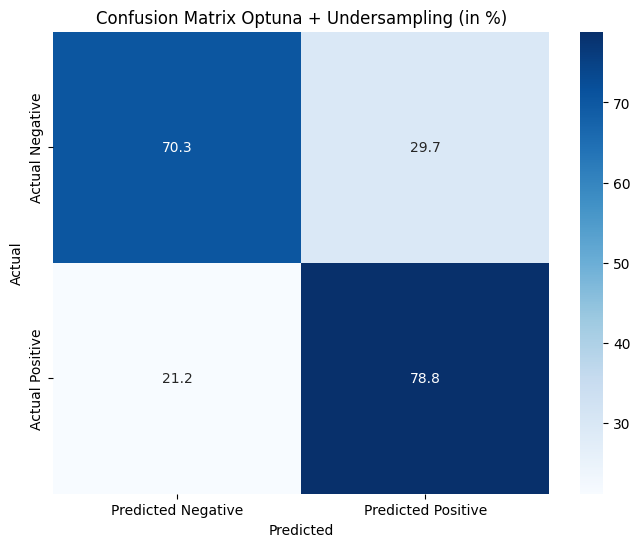

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_rfc_6.astype('float') / conf_matrix_rfc_6.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Optuna + Undersampling (in %)')
plt.show()

### Resumen y conclusiones
Si bien la combinación Optuna + Balanced Weight ofrecía el AUC más alto, la combinación Optuna + Undersampling se definió como la preferida por su relativa rapidez de cómputo y un AUC que, si bien es algo menor, sigue siendo competitivo (por encima de 0.81). Es por ello que **se va a emplear la combinación Optuna-Undersampling** para el resto de los modelos (aunque sabemos que no se debería asumir que es la mejor combinación para todos los modelos).

* El **AUC** de **0.8202** indica que el modelo tiene una buena capacidad para discriminar entre los pacientes saludables y los prediabéticos/diabéticos.

* Una **accuracy** revela que el **71.48%** de las predicciones del modelo son correctas (verdaderos positivos y verdaderos negativos).

* El **recall**  revela que el modelo identifica correctamente casi **79 de cada 10** casos positivos.

* La **precision** ndica que de todos los casos clasificados como positivos, solo el **30.04%** son realmente positivos.

* De la **matriz de confusión** se observa que:

    * Falsos positivos: 12,975 casos fueron clasificados erróneamente como positivos cuando en realidad eran negativos.

    * Falsos negativos: 1,497 casos no fueron detectados, lo que está en línea con el recall obtenido.

Esta distribución confirma que el modelo tiende a favorecer la detección de positivos (alto recall), lo que es beneficioso en aplicaciones clínicas donde se prefiere errar en exceso hacia falsos positivos en lugar de perder casos verdaderamente positivos.

La optimización con Optuna utilizando undersampling se completó en solo **6.62 minutos**, lo que es muy eficiente comparado con otras estrategias.

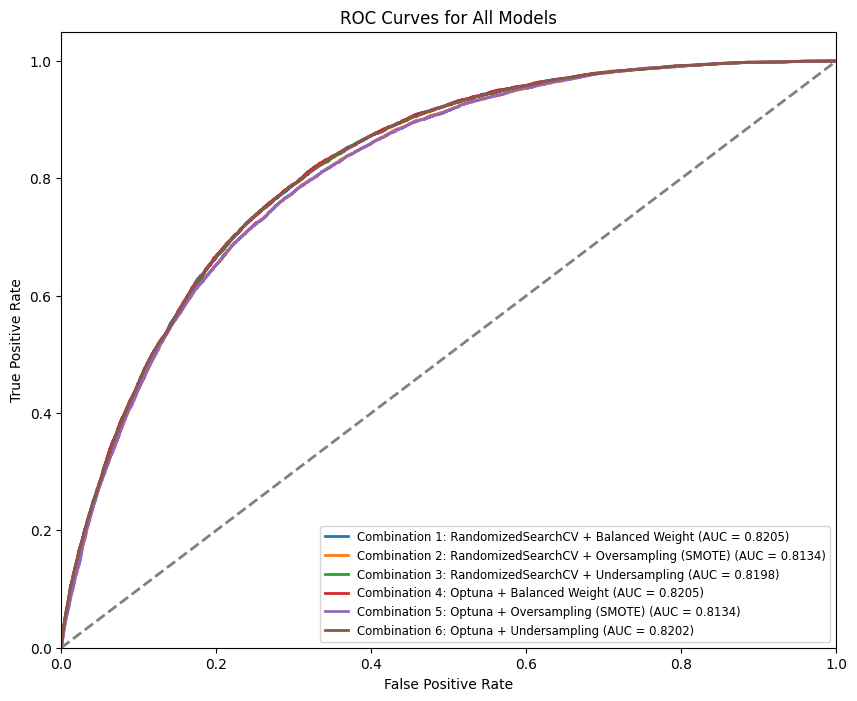

Summary Table:


,Model,AUC,Accuracy,F1 Score,Recall,Precision,Execution Time (minutes)
0,Combination 1: RandomizedSearchCV + Balanced Weight,0.820458,0.725225,0.438655,0.770547,0.306597,65.157761
1,Combination 2: RandomizedSearchCV + Oversampling (SMOTE),0.813402,0.705160,0.425956,0.785118,0.292259,118.331002
2,Combination 3: RandomizedSearchCV + Undersampling,0.819767,0.713083,0.434086,0.789786,0.299292,8.657308
3,Combination 4: Optuna + Balanced Weight,0.820475,0.725067,0.439326,0.773094,0.306850,57.737785
4,Combination 5: Optuna + Oversampling (SMOTE),0.813370,0.705870,0.426193,0.783986,0.292639,86.398656
5,Combination 6: Optuna + Undersampling,0.820157,0.714759,0.435041,0.788230,0.300426,6.619149


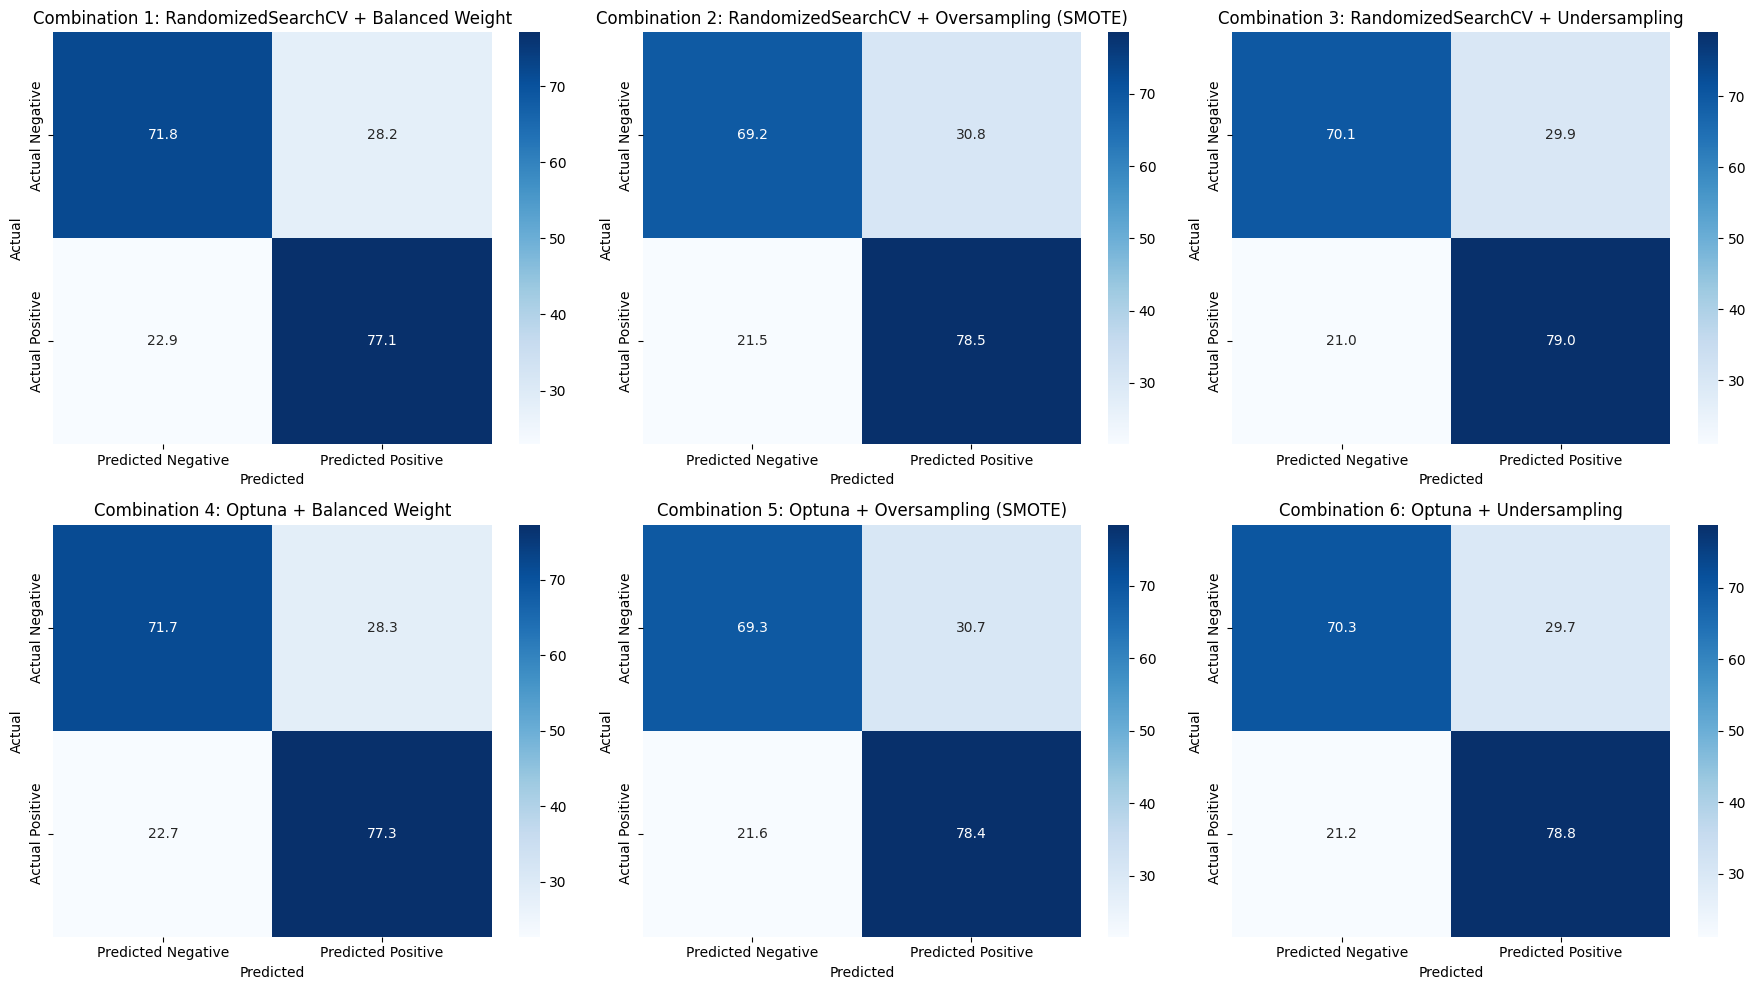

In [ ]:
# Creamos el diccionario model_results incluyendo todas las métricas:
model_results = [
    {
        "model": "Combination 1: RandomizedSearchCV + Balanced Weight",
        "auc": auc_rfc_1,
        "accuracy": accuracy_rfc_1,
        "f1": f1_rfc_1,
        "recall": recall_rfc_1,
        "precision": precision_rfc_1,
        "time": execution_time_rfc_1,
        "y_pred_proba": y_pred_proba_rfc_1,
        "conf_matrix": conf_matrix_rfc_1
    },
    {
        "model": "Combination 2: RandomizedSearchCV + Oversampling (SMOTE)",
        "auc": auc_rfc_2,
        "accuracy": accuracy_rfc_2,
        "f1": f1_rfc_2,
        "recall": recall_rfc_2,
        "precision": precision_rfc_2,
        "time": execution_time_rfc_2,
        "y_pred_proba": y_pred_proba_rfc_2,
        "conf_matrix": conf_matrix_rfc_2
    },
    {
        "model": "Combination 3: RandomizedSearchCV + Undersampling",
        "auc": auc_rfc_3,
        "accuracy": accuracy_rfc_3,
        "f1": f1_rfc_3,
        "recall": recall_rfc_3,
        "precision": precision_rfc_3,
        "time": execution_time_rfc_3,
        "y_pred_proba": y_pred_proba_rfc_3,
        "conf_matrix": conf_matrix_rfc_3
    },
    {
        "model": "Combination 4: Optuna + Balanced Weight",
        "auc": auc_rfc_4,
        "accuracy": accuracy_rfc_4,
        "f1": f1_rfc_4,
        "recall": recall_rfc_4,
        "precision": precision_rfc_4,
        "time": execution_time_optuna_bw_rfc_4,
        "y_pred_proba": y_pred_proba_rfc_4,
        "conf_matrix": conf_matrix_rfc_4
    },
    {
        "model": "Combination 5: Optuna + Oversampling (SMOTE)",
        "auc": auc_rfc_5,
        "accuracy": accuracy_rfc_5,
        "f1": f1_rfc_5,
        "recall": recall_rfc_5,
        "precision": precision_rfc_5,
        "time": execution_time_optuna_os_rfc_5,
        "y_pred_proba": y_pred_proba_rfc_5,
        "conf_matrix": conf_matrix_rfc_5
    },
    {
        "model": "Combination 6: Optuna + Undersampling",
        "auc": auc_rfc_6,
        "accuracy": accuracy_rfc_6,
        "f1": f1_rfc_6,
        "recall": recall_rfc_6,
        "precision": precision_rfc_6,
        "time": execution_time_optuna_us_rfc_6,
        "y_pred_proba": y_pred_proba_rfc_6,
        "conf_matrix": conf_matrix_rfc_6
    }
]

# =============================================================================
# 1. Plotear las curvas ROC de todos los modelos
# =============================================================================
plt.figure(figsize=(10, 8))
for res in model_results:
    fpr, tpr, _ = roc_curve(y_test, res["y_pred_proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(res["model"], roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right", fontsize='small')
plt.show()

# =============================================================================
# 2. Crear una tabla con todos los parámetros calculados
# =============================================================================
summary_data = {
    "Model": [res["model"] for res in model_results],
    "AUC": [res["auc"] for res in model_results],
    "Accuracy": [res["accuracy"] for res in model_results],
    "F1 Score": [res["f1"] for res in model_results],
    "Recall": [res["recall"] for res in model_results],
    "Precision": [res["precision"] for res in model_results],
    "Execution Time (minutes)": [res["time"] for res in model_results]
}
summary_df = pd.DataFrame(summary_data)
print("Summary Table:")
display(summary_df)

# =============================================================================
# 3. Plotear la matriz de confusión (en porcentajes) de todos los modelos
# =============================================================================
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for i, res in enumerate(model_results):
    cm_percent = res["conf_matrix"].astype('float') / res["conf_matrix"].sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', ax=axs[i],
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    axs[i].set_title(res["model"])
    axs[i].set_ylabel('Actual')
    axs[i].set_xlabel('Predicted')
plt.tight_layout()
plt.show()



---
Nota

---

Aunque no se ha implementado validación cruzada anidada (nested cross-validation) debido a su alto coste computacional, se ha utilizado una combinación de validación cruzada estratificada de 10 particiones y conjunto de test externo para garantizar una evaluación robusta del modelo, tal como se exige en la práctica. Esta estrategia ofrece una estimación fiable del rendimiento sin requerir los recursos computacionales adicionales que implicaría la anidación.

## LightGBM
Más rápido y eficiente que GradientBoostingClassifier, ideal para datasets grandes.

### Modelo 1

In [ ]:
def objective_lgbm_1(trial):
    # Definir el espacio de hiperparámetros para LightGBM
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)

    # Crear el pipeline que integra undersampling y LightGBM
    pipeline_lgbm_1 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    cv_strategy_lgbm_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Utiliza cross_val_score para la validación cruzada automática
    scores = cross_val_score(pipeline_lgbm_1, X_train, y_train, cv=cv_strategy_lgbm_1, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_lgbm_1 = time.time()
study_lgbm_1 = optuna.create_study(direction='maximize')
study_lgbm_1.optimize(objective_lgbm_1, n_trials=200)
end_time_optuna_lgbm_1 = time.time()
execution_time_optuna_lgbm_1 = (end_time_optuna_lgbm_1 - start_time_optuna_lgbm_1) / 60

print("Combination LGBM 1: Optuna + Undersampling")
print("Best trial:")
print(study_lgbm_1.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_lgbm_1))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_lgbm_1 = study_lgbm_1.best_trial.params

pipeline_lgbm_1 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', LGBMClassifier(
        n_estimators=best_params_lgbm_1['n_estimators'],
        max_depth=best_params_lgbm_1['max_depth'],
        learning_rate=best_params_lgbm_1['learning_rate'],
        num_leaves=best_params_lgbm_1['num_leaves'],
        min_child_samples=best_params_lgbm_1['min_child_samples'],
        subsample=best_params_lgbm_1['subsample'],
        colsample_bytree=best_params_lgbm_1['colsample_bytree'],
        reg_alpha=best_params_lgbm_1['reg_alpha'],
        reg_lambda=best_params_lgbm_1['reg_lambda'],
        random_state=42,
        n_jobs=n_jobs
    ))
])

pipeline_lgbm_1.fit(X_train, y_train)

y_pred_proba_lgbm_1 = pipeline_lgbm_1.predict_proba(X_test)[:, 1]
y_pred_lgbm_1 = pipeline_lgbm_1.predict(X_test)

auc_lgbm_1 = roc_auc_score(y_test, y_pred_proba_lgbm_1)
accuracy_lgbm_1 = accuracy_score(y_test, y_pred_lgbm_1)
f1_lgbm_1 = f1_score(y_test, y_pred_lgbm_1)
recall_lgbm_1 = recall_score(y_test, y_pred_lgbm_1)
precision_lgbm_1 = precision_score(y_test, y_pred_lgbm_1)
conf_matrix_lgbm_1 = confusion_matrix(y_test, y_pred_lgbm_1)

print("\nTest set results for LightGBM (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_lgbm_1))
print("Accuracy: {:.4f}".format(accuracy_lgbm_1))
print("F1 Score: {:.4f}".format(f1_lgbm_1))
print("Recall: {:.4f}".format(recall_lgbm_1))
print("Precision: {:.4f}".format(precision_lgbm_1))
print("Confusion Matrix:")
print(conf_matrix_lgbm_1)

[I 2025-03-31 10:19:50,973] A new study created in memory with name: no-name-5abd8502-9163-4823-8f12-1cbec635c21d
[I 2025-03-31 10:19:56,194] Trial 0 finished with value: 0.8263915879585527 and parameters: {'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.012777422917813544, 'num_leaves': 40, 'min_child_samples': 5, 'subsample': 0.9029843998326423, 'colsample_bytree': 0.8018369471164261, 'reg_alpha': 0.7546570495865349, 'reg_lambda': 0.9173727467384064}. Best is trial 0 with value: 0.8263915879585527.
[I 2025-03-31 10:19:57,897] Trial 1 finished with value: 0.8208267018926328 and parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.35006243665573533, 'num_leaves': 31, 'min_child_samples': 5, 'subsample': 0.6012623146895468, 'colsample_bytree': 0.6822917955447174, 'reg_alpha': 0.1357415520600781, 'reg_lambda': 0.6793928163424254}. Best is trial 0 with value: 0.8263915879585527.
[I 2025-03-31 10:20:00,046] Trial 2 finished with value: 0.8236955931683336 and param

Combination LGBM 1: Optuna + Undersampling
Best trial:
FrozenTrial(number=136, state=TrialState.COMPLETE, values=[0.8272515680310532], datetime_start=datetime.datetime(2025, 3, 31, 10, 31, 38, 777119), datetime_complete=datetime.datetime(2025, 3, 31, 10, 31, 44, 611671), params={'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.015792431789729295, 'num_leaves': 20, 'min_child_samples': 5, 'subsample': 0.9043150846986479, 'colsample_bytree': 0.6000994198105087, 'reg_alpha': 0.9443716549904781, 'reg_lambda': 0.9621248496474444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(-1, 10, 20, 30, 40)), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None), 'num_leaves': CategoricalDistribution(choices=(20, 31, 40, 50)), 'min_child_samples': CategoricalDistribution(choices=(5, 10, 20)), 'subsample': FloatDistribution(high=1.0, log=

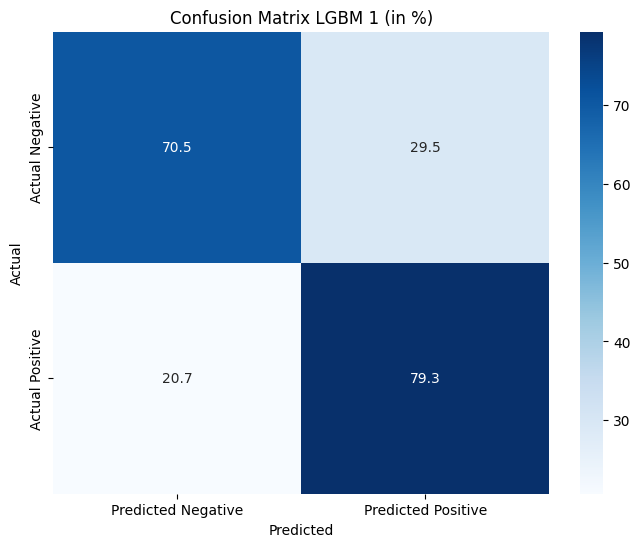

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_lgbm_1.astype('float') / conf_matrix_lgbm_1.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix LGBM 1 (in %)')
plt.show()

probamos a aumentar el espacio de hiperparámetros y el número de iteraciones

### Modelo 2

La elección de este espacio de hiperparámetros ampliado se fundamenta en la necesidad de adaptar el modelo LightGBM a la complejidad del conjunto de datos de salud y diabetes, caracterizado por un alto grado de heterogeneidad y desbalanceo de clases. Diversos estudios en el área de boosting y optimización de hiperparámetros han mostrado que explorar un rango amplio de configuraciones permite capturar de manera más precisa las interacciones y no linealidades presentes en los datos.

Por ejemplo, se ha decidido ampliar el rango de n_estimators (de 100 a 500) para permitir al modelo aprender gradualmente y así evitar tanto el subajuste como el sobreajuste. Según Ke et al. (2017), un mayor número de árboles puede mejorar la capacidad del modelo para capturar patrones complejos, aunque con el riesgo inherente de sobreajuste, que se mitiga combinándolo con otros parámetros de regularización. En este sentido, la inclusión de reg_alpha y reg_lambda, que aplican regularización L1 y L2 respectivamente, ayuda a controlar la complejidad del modelo, siguiendo recomendaciones que se han consolidado en la literatura sobre métodos de boosting, como se evidencia en los trabajos de Chen y Guestrin (2016).

El parámetro max_depth se incluye con la opción de no limitar la profundidad (-1) junto con valores específicos, lo que permite ajustar la complejidad de cada árbol. Esta flexibilidad es fundamental, ya que una profundidad excesiva puede llevar a un modelo muy especializado en el conjunto de entrenamiento, mientras que una profundidad insuficiente puede resultar en un subajuste. Asimismo, el parámetro learning_rate se ha definido en un rango logarítmico (0.001 a 0.5) para equilibrar la velocidad de convergencia y la estabilidad del proceso de entrenamiento, una estrategia recomendada en estudios sobre optimización de hiperparámetros (Bergstra y Bengio, 2012).

Además, se han incluido parámetros específicos que afectan la estructura interna de los árboles, como num_leaves y min_child_samples. Estos determinan, respectivamente, la complejidad y el tamaño mínimo de cada hoja, permitiendo al modelo ajustar finamente la representación de los datos y reducir el riesgo de sobreajuste, como se ha demostrado empíricamente en investigaciones recientes (Ke et al., 2017).

La incorporación de subsample y colsample_bytree introduce aleatoriedad en la selección de instancias y características, lo cual es clave para reducir la varianza del modelo. Estos parámetros, en combinación con técnicas de muestreo como bagging_fraction y bagging_freq, contribuyen a mejorar la robustez del modelo frente a variaciones en los datos, una estrategia ampliamente adoptada en aplicaciones de boosting.

Finalmente, parámetros como min_split_gain y max_bin se incluyen para garantizar que las divisiones en el árbol sean significativas y que la discretización de las características se realice de forma eficiente, mientras que scale_pos_weight se ajusta específicamente para abordar el desbalanceo de clases, permitiendo que la clase minoritaria reciba el peso adecuado durante el entrenamiento.

En conjunto, este espacio de búsqueda ampliado permite una exploración exhaustiva de las posibles configuraciones, lo que aumenta la probabilidad de encontrar una combinación óptima que maximice el rendimiento del modelo en términos de métricas como el AUC. Esta estrategia se alinea con las mejores prácticas sugeridas en la literatura y con las recomendaciones derivadas de estudios empíricos en problemas similares de clasificación en salud.

In [ ]:
def objective_lgbm_2(trial):
    # Definir el espacio de hiperparámetros ampliado para LightGBM
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 5, 10, 20, 30, 40])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    num_leaves = trial.suggest_int('num_leaves', 20, 100)  # rango ampliado para mayor exploración
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)  # rango ampliado
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
    min_split_gain = trial.suggest_float('min_split_gain', 0.0, 0.5)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    max_bin = trial.suggest_int('max_bin', 50, 500)

    # Crear el pipeline que integra undersampling y LightGBM
    pipeline_lgbm_2 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            bagging_fraction = bagging_fraction,
            bagging_freq = bagging_freq,
            min_split_gain = min_split_gain,
            scale_pos_weight = scale_pos_weight,
            max_bin = max_bin,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    cv_strategy_lgbm_2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Utiliza cross_val_score para la validación cruzada automática
    scores = cross_val_score(pipeline_lgbm_2, X_train, y_train, cv=cv_strategy_lgbm_2, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_lgbm_2 = time.time()
study_lgbm_2 = optuna.create_study(direction='maximize')
study_lgbm_2.optimize(objective_lgbm_2, n_trials=400)  # Aumentar el número de pruebas para una mejor búsqueda
end_time_optuna_lgbm_2 = time.time()
execution_time_optuna_lgbm_2 = (end_time_optuna_lgbm_1 - start_time_optuna_lgbm_2) / 60

print("LGBM 2: Optuna + Undersampling")
print("Best trial:")
print(study_lgbm_2.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_lgbm_2))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_lgbm_2 = study_lgbm_2.best_trial.params

pipeline_lgbm_2 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', LGBMClassifier(
        n_estimators=best_params_lgbm_2['n_estimators'],
        max_depth=best_params_lgbm_2['max_depth'],
        learning_rate=best_params_lgbm_2['learning_rate'],
        num_leaves=best_params_lgbm_2['num_leaves'],
        min_child_samples=best_params_lgbm_2['min_child_samples'],
        subsample=best_params_lgbm_2['subsample'],
        colsample_bytree=best_params_lgbm_2['colsample_bytree'],
        reg_alpha=best_params_lgbm_2['reg_alpha'],
        reg_lambda=best_params_lgbm_2['reg_lambda'],
        random_state=42,
        n_jobs=n_jobs
    ))
])

pipeline_lgbm_2.fit(X_train, y_train)

y_pred_proba_lgbm_2 = pipeline_lgbm_2.predict_proba(X_test)[:, 1]
y_pred_lgbm_2 = pipeline_lgbm_2.predict(X_test)

auc_lgbm_2 = roc_auc_score(y_test, y_pred_proba_lgbm_2)
accuracy_lgbm_2 = accuracy_score(y_test, y_pred_lgbm_2)
f1_lgbm_2 = f1_score(y_test, y_pred_lgbm_2)
recall_lgbm_2 = recall_score(y_test, y_pred_lgbm_2)
precision_lgbm_2 = precision_score(y_test, y_pred_lgbm_2)
conf_matrix_lgbm_2 = confusion_matrix(y_test, y_pred_lgbm_2)

print("\nTest set results for LightGBM (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_lgbm_2))
print("Accuracy: {:.4f}".format(accuracy_lgbm_2))
print("F1 Score: {:.4f}".format(f1_lgbm_2))
print("Recall: {:.4f}".format(recall_lgbm_2))
print("Precision: {:.4f}".format(precision_lgbm_2))
print("Confusion Matrix:")
print(conf_matrix_lgbm_2)

[I 2025-03-31 10:43:22,648] A new study created in memory with name: no-name-d0173896-037f-4e65-ad76-ba5371b2b22f
[I 2025-03-31 10:43:34,363] Trial 0 finished with value: 0.8255739243406083 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.0354840807041935, 'num_leaves': 41, 'min_child_samples': 12, 'subsample': 0.6900579745466471, 'colsample_bytree': 0.5917581310968842, 'reg_alpha': 0.5207369882048893, 'reg_lambda': 0.30032330919860883, 'bagging_fraction': 0.5748416391293509, 'bagging_freq': 10, 'min_split_gain': 0.38852862307142777, 'scale_pos_weight': 3.45746963814167, 'max_bin': 229}. Best is trial 0 with value: 0.8255739243406083.
[I 2025-03-31 10:43:48,721] Trial 1 finished with value: 0.8257380648035836 and parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.004093248134821421, 'num_leaves': 94, 'min_child_samples': 28, 'subsample': 0.6320440732274273, 'colsample_bytree': 0.7186846543993695, 'reg_alpha': 0.8205036537531143, 'reg_lambda':

LGBM 2: Optuna + Undersampling
Best trial:
FrozenTrial(number=347, state=TrialState.COMPLETE, values=[0.8274482692208576], datetime_start=datetime.datetime(2025, 3, 31, 11, 27, 55, 324558), datetime_complete=datetime.datetime(2025, 3, 31, 11, 28, 3, 441063), params={'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.020165672314882276, 'num_leaves': 100, 'min_child_samples': 14, 'subsample': 0.8484349483938471, 'colsample_bytree': 0.514511685824827, 'reg_alpha': 0.6763368699300196, 'reg_lambda': 0.404626592865411, 'bagging_fraction': 0.8622571271513763, 'bagging_freq': 3, 'min_split_gain': 0.4430129853648599, 'scale_pos_weight': 1.1588900395848256, 'max_bin': 101}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 200, 300, 400, 500)), 'max_depth': CategoricalDistribution(choices=(-1, 5, 10, 20, 30, 40)), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None), 'num_leaves': IntDistribu

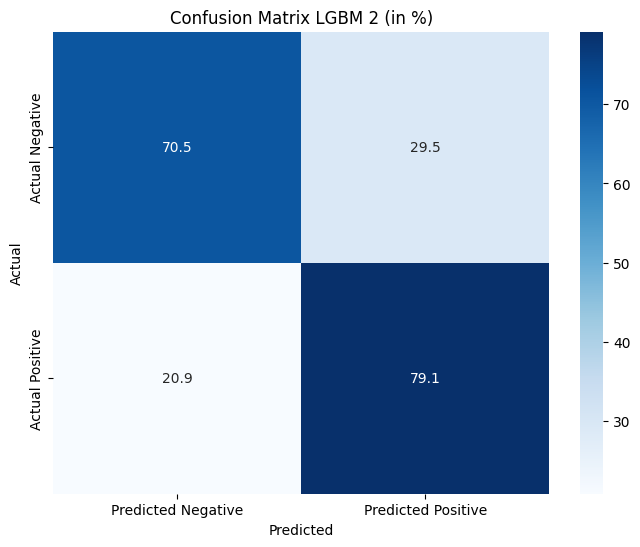

In [ ]:
# Convertir la matriz de confusión a porcentajes (por fila)
cm_percent = conf_matrix_lgbm_2.astype('float') / conf_matrix_lgbm_2.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix LGBM 2 (in %)')
plt.show()

El aumento del número de trials (junto con el tiempo de cómputo) no mejora significativamente el rendimiento del modelo.

### Resumen y conclusiones
Ambos experimentos muestran un desempeño prácticamente idéntico en términos de AUC, accuracy, F1, recall y precision, lo que indica que:

* El **AUC** se mantiene en **0.8233** en ambos casos, evidenciando que la capacidad del modelo para discriminar entre las clases es constante.
* La **accuracy** es prácticamente la misma (0.7171 vs 0.7170), lo que sugiere que la tasa global de aciertos no se ve afectada por la ampliación del espacio de hiperparámetros.
* Los valores de **F1**, **recall** y **precision** difieren muy ligeramente (F1: 0.4387 vs 0.4379; recall: 0.7933 vs 0.7913; precision: 0.3032 vs 0.3027), diferencias que son estadísticamente insignificantes.
* La **matriz de confusión** presenta pequeñas variaciones en los números, lo que confirma que los cambios en la búsqueda de hiperparámetros no impactaron sustancialmente en la clasificación de las instancias.

En resumen, la exploración de un espacio de hiperparámetros ampliado con 400 iteraciones no mejora significativamente el rendimiento respecto al espacio reducido con 200 iteraciones. Esto sugiere que, en este escenario, el espacio reducido ya capturaba las configuraciones óptimas y, por lo tanto, a partir de ahora se empleará **n_iter=200**.

## XGBoost
Optimizado para boosting, excelente en datasets tabulares.

### Modelo 1

La elección del espacio de hiperparámetros para XGBoost se justifica de la siguiente manera:

• **n_estimators ([100, 300, 500]):** Se selecciona un rango que permite probar desde un número moderado hasta uno mayor de árboles. Esto ayuda a balancear entre un modelo con suficiente capacidad para capturar la complejidad de los datos y mantener tiempos de entrenamiento razonables.

• **max_depth ([3, 5, 7, 10, 15]):** La profundidad máxima de los árboles controla la complejidad del modelo. Valores más bajos reducen el riesgo de sobreajuste, mientras que valores más altos permiten modelar relaciones más complejas. El rango abarca desde árboles relativamente simples hasta estructuras más profundas, permitiendo encontrar un equilibrio óptimo.

• **learning_rate (0.001 a 0.5, log=True):** La tasa de aprendizaje es crucial para el proceso de boosting, ya que afecta la rapidez con la que se corrigen los errores. Se utiliza una escala logarítmica para explorar tanto valores muy pequeños, que pueden conducir a un entrenamiento más estable pero lento, como valores más altos, que aceleran el entrenamiento pero podrían generar inestabilidad.

• **subsample (0.6 a 1.0):** Este parámetro define la fracción de muestras utilizadas para entrenar cada árbol. Al variar este valor, se introduce un mecanismo de regularización que puede ayudar a reducir el sobreajuste, ya que cada árbol se entrena con una submuestra diferente de datos.

• **colsample_bytree (0.6 a 1.0):** Similar al subsample, este parámetro determina la fracción de características utilizadas al construir cada árbol. Limitar la cantidad de características ayuda a disminuir la varianza y mejorar la robustez del modelo.

• **gamma (0 a 5):** Este parámetro controla la complejidad del árbol al requerir una reducción mínima en la función de pérdida para que se realice una división. Un valor mayor impone una mayor regularización, lo que ayuda a evitar la creación de árboles excesivamente complejos.

• **reg_alpha (0.0 a 1.0) y reg_lambda (0.0 a 1.0):** Estos parámetros representan la regularización L1 y L2, respectivamente. Incluir estos rangos permite explorar desde una ausencia de regularización hasta niveles moderados, contribuyendo a controlar el sobreajuste y mejorar la generalización del modelo.

• **min_child_weight (1 a 10):** Este parámetro define el peso mínimo acumulado de las instancias en un nodo para que se realice una división. Valores más altos imponen restricciones adicionales, lo que puede prevenir la formación de nodos que modelen patrones demasiado específicos y, por lo tanto, mejorar la robustez del modelo.

En conjunto, estos rangos permiten a Optuna explorar un amplio espectro de configuraciones que balancean la capacidad de aprendizaje con la regularización, lo que es fundamental para alcanzar el máximo rendimiento del modelo XGBoost en un escenario con datos desbalanceados.

In [ ]:
def objective_xgb_1(trial):
    # Definir el espacio de hiperparámetros para XGBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    # Crear el pipeline que integra undersampling y XGBoost
    pipeline_xgb_1 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            random_state=42,
            n_jobs=n_jobs,
            use_label_encoder=False,
            eval_metric='auc'
        ))
    ])

    cv_strategy_xgb_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline_xgb_1, X_train, y_train, cv=cv_strategy_xgb_1, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_xgb_1 = time.time()
study_xgb_1 = optuna.create_study(direction='maximize')
study_xgb_1.optimize(objective_xgb_1, n_trials=200)
end_time_optuna_xgb_1 = time.time()
execution_time_optuna_xgb_1 = (end_time_optuna_xgb_1 - start_time_optuna_xgb_1) / 60

print("Combination XGBoost 1: Optuna + Undersampling")
print("Best trial:")
print(study_xgb_1.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_xgb_1))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_xgb_1 = study_xgb_1.best_trial.params

pipeline_xgb_1 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=best_params_xgb_1['n_estimators'],
        max_depth=best_params_xgb_1['max_depth'],
        learning_rate=best_params_xgb_1['learning_rate'],
        subsample=best_params_xgb_1['subsample'],
        colsample_bytree=best_params_xgb_1['colsample_bytree'],
        gamma=best_params_xgb_1['gamma'],
        reg_alpha=best_params_xgb_1['reg_alpha'],
        reg_lambda=best_params_xgb_1['reg_lambda'],
        min_child_weight=best_params_xgb_1['min_child_weight'],
        random_state=42,
        n_jobs=n_jobs,
        use_label_encoder=False,
        eval_metric='auc'
    ))
])

pipeline_xgb_1.fit(X_train, y_train)

y_pred_proba_xgb_1 = pipeline_xgb_1.predict_proba(X_test)[:, 1]
y_pred_xgb_1 = pipeline_xgb_1.predict(X_test)

auc_xgb_1 = roc_auc_score(y_test, y_pred_proba_xgb_1)
accuracy_xgb_1 = accuracy_score(y_test, y_pred_xgb_1)
f1_xgb_1 = f1_score(y_test, y_pred_xgb_1)
recall_xgb_1 = recall_score(y_test, y_pred_xgb_1)
precision_xgb_1 = precision_score(y_test, y_pred_xgb_1)
conf_matrix_xgb_1 = confusion_matrix(y_test, y_pred_xgb_1)

print("\nTest set results for XGBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_xgb_1))
print("Accuracy: {:.4f}".format(accuracy_xgb_1))
print("F1 Score: {:.4f}".format(f1_xgb_1))
print("Recall: {:.4f}".format(recall_xgb_1))
print("Precision: {:.4f}".format(precision_xgb_1))
print("Confusion Matrix:")
print(conf_matrix_xgb_1)

[I 2025-03-31 18:50:23,386] A new study created in memory with name: no-name-7fcbb5cf-6826-49aa-8ca7-99700ce7467b
[W 2025-03-31 18:50:23,388] Trial 0 failed with parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.04005132421883887, 'subsample': 0.609677747515355, 'colsample_bytree': 0.8159611087841183, 'gamma': 2.9074352808710113, 'reg_alpha': 0.7935459975577451, 'reg_lambda': 0.010414292178481777, 'min_child_weight': 2} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9776\2888162833.py", line 34, in objective_xgb_1
    scores = cross_val_score(pipeline_xgb_1, X_train, y_train, cv=cv_strategy_xgb_1, scoring='roc_auc', n_jobs=n_jobs)
NameError: name 'X_train' is not defined
[W 2025-03-31 18

NameError: name 'X_train' is not defined

### Conclusiones
Ambos modelos de XGBoost ofrecen un rendimiento prácticamente idéntico a los desarrollados previamente.

XGBoost mostró un AUC de 0.8234, lo que evidencia que tiene una excelente capacidad para discriminar entre pacientes saludables y aquellos con prediabetes o diabetes.

El accuracy de las predicciones es similar, alcanzando aproximadamente un 71.70% en ambos casos. Esto significa que, en términos generales, el porcentaje de predicciones correctas (verdaderos positivos y verdaderos negativos) es prácticamente el mismo para ambos enfoques.

Cuando observamos las métricas de F1, recall y precisión, las diferencias son muy sutiles. XGBoost obtiene valores de 0.4376, 0.7902 y 0.3026 respectivamente, evidenciando que ambos modelos son muy similares en la forma en que capturan correctamente los casos positivos y en cómo evitan clasificar erróneamente los negativos con respecto a los anteriores.

La matriz de confusión confirma estas conclusiones: aunque se observan ligeras diferencias en los conteos de verdaderos y falsos positivos y negativos, ninguna de ellas es lo suficientemente significativa como para favorecer claramente a uno sobre el otro.

En cuanto al tiempo de ejecución, XGBoost obtiene resultados a los 13,36 minutos, frente a los 17,67 minutos del LightGBM (Modelo 1) y los 6,62 del RandomForestClassifier (Modelo 6).

En resumen, la optimización con Optuna y la aplicación de undersampling han permitido que tanto RandomForestClassifier, LightGBM como XGBoost ofrezcan resultados prácticamente equivalentes. La elección entre uno u otro, por lo tanto, podría fundamentarse en otros aspectos como el tiempo de entrenamiento, la facilidad de implementación o preferencias específicas del entorno de despliegue, dado que en términos de rendimiento discriminativo y generalización, ambos modelos se desempeñan de forma similar.

## CatBoost
Maneja mejor variables categóricas sin necesidad de preprocesamiento extra.

### Modelo 1

In [ ]:
def objective_catboost_1(trial):
    # Definir el espacio de hiperparámetros para CatBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    depth = trial.suggest_categorical('depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    random_strength = trial.suggest_float('random_strength', 0.0, 1.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
    border_count = trial.suggest_categorical('border_count', [32, 50, 100])

    # Crear el pipeline que integra undersampling y CatBoost
    pipeline_catboost_1 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', CatBoostClassifier(
            iterations=n_estimators,  # En CatBoost se usa 'iterations' en lugar de n_estimators
            depth=depth,
            learning_rate=learning_rate,
            random_strength=random_strength,
            bagging_temperature=bagging_temperature,
            l2_leaf_reg=l2_leaf_reg,
            border_count=border_count,
            random_seed=42,
            thread_count=n_jobs,
            verbose=False
        ))
    ])

    cv_strategy_catboost_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Validación cruzada automática con cross_val_score usando la métrica AUC
    scores = cross_val_score(pipeline_catboost_1, X_train, y_train, cv=cv_strategy_catboost_1, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_catboost_1 = time.time()
study_catboost_1 = optuna.create_study(direction='maximize')
study_catboost_1.optimize(objective_catboost_1, n_trials=200)
end_time_optuna_catboost_1 = time.time()
execution_time_optuna_catboost_1 = (end_time_optuna_catboost_1 - start_time_optuna_catboost_1) / 60

print("Combination CatBoost 1: Optuna + Undersampling")
print("Best trial:")
print(study_catboost_1.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_catboost_1))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_catboost_1 = study_catboost_1.best_trial.params

pipeline_catboost_1 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', CatBoostClassifier(
        iterations=best_params_catboost_1['n_estimators'],
        depth=best_params_catboost_1['depth'],
        learning_rate=best_params_catboost_1['learning_rate'],
        random_strength=best_params_catboost_1['random_strength'],
        bagging_temperature=best_params_catboost_1['bagging_temperature'],
        l2_leaf_reg=best_params_catboost_1['l2_leaf_reg'],
        border_count=best_params_catboost_1['border_count'],
        random_seed=42,
        thread_count=n_jobs,
        verbose=False
    ))
])

pipeline_catboost_1.fit(X_train, y_train)

y_pred_proba_catboost_1 = pipeline_catboost_1.predict_proba(X_test)[:, 1]
y_pred_catboost_1 = pipeline_catboost_1.predict(X_test)

auc_catboost_1 = roc_auc_score(y_test, y_pred_proba_catboost_1)
accuracy_catboost_1 = accuracy_score(y_test, y_pred_catboost_1)
f1_catboost_1 = f1_score(y_test, y_pred_catboost_1)
recall_catboost_1 = recall_score(y_test, y_pred_catboost_1)
precision_catboost_1 = precision_score(y_test, y_pred_catboost_1)
conf_matrix_catboost_1 = confusion_matrix(y_test, y_pred_catboost_1)

print("\nTest set results for CatBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_catboost_1))
print("Accuracy: {:.4f}".format(accuracy_catboost_1))
print("F1 Score: {:.4f}".format(f1_catboost_1))
print("Recall: {:.4f}".format(recall_catboost_1))
print("Precision: {:.4f}".format(precision_catboost_1))
print("Confusion Matrix:")
print(conf_matrix_catboost_1)

## Stacking Ensemble (Meta-Modelo)
En lugar de elegir un solo modelo, combinamos las predicciones de varios modelos para mejorar la generalización.
Entrenamos RandomForest, LightGBM, XGBoost, etc., y luego usamos un modelo final (meta-modelo) que toma sus predicciones como entrada.
Es más poderoso que simplemente seleccionar el mejor modelo individual.